##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/video/video_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Video classification with a 3D convolutional neural network

This tutorial demonstrates training a 3D convolutional neural network (CNN) for video classification using the [UCF101](https://www.crcv.ucf.edu/data/UCF101.php) action recognition dataset. A 3D CNN uses a three-dimensional filter to perform convolutions. The kernel is able to slide in three directions, whereas in a 2D CNN it can slide in two dimensions. The model is based on the work published in [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017).  In this tutorial, you will:

* Build an input pipeline
* Build a 3D convolutional neural network model with residual connections using Keras functional API
* Train the model
* Evaluate and test the model

This video classification tutorial is the second part in a series of TensorFlow video tutorials. Here are the other three tutorials:

- [Load video data](https://www.tensorflow.org/tutorials/load_data/video): This tutorial explains much of the code used in this document.
- [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet): Get familiar with the MoViNet models that are available on TF Hub.
- [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet): This tutorial explains how to use a pre-trained video classification model trained on a different dataset with the UCF-101 dataset.

## Setup

Begin by installing and importing some necessary libraries, including:
[remotezip](https://github.com/gtsystem/python-remotezip) to inspect the contents of a ZIP file, [tqdm](https://github.com/tqdm/tqdm) to use a progress bar, [OpenCV](https://opencv.org/) to process video files, [einops](https://github.com/arogozhnikov/einops/tree/master/docs) for performing more complex tensor operations, and [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs) for embedding data in a Jupyter notebook.

In [2]:
!pip install remotezip tqdm opencv-python einops 
!pip install -U tensorflow keras

In [1]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

## Load and preprocess video data

The hidden cell below defines helper functions to download a slice of data from the UCF-101 dataset, and load it into a `tf.data.Dataset`. You can learn more about the specific preprocessing steps in the [Loading video data tutorial](../load_data/video.ipynb), which walks you through this code in more detail.

The `FrameGenerator` class at the end of the hidden block is the most important utility here. It creates an iterable object that can feed data into the TensorFlow data pipeline. Specifically, this class contains a Python generator that loads the video frames along with its encoded label. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

In [2]:
#@title

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [3]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [05:37<00:00,  1.13s/it]


val :


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


test :


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


 12%|█▏        | 36/300 [00:03<00:31,  8.47it/s]

 12%|█▏        | 37/300 [00:03<00:32,  8.12it/s]

 13%|█▎        | 39/300 [00:04<00:30,  8.63it/s]

 14%|█▎        | 41/300 [00:04<00:29,  8.70it/s]

 14%|█▍        | 43/300 [00:04<00:26,  9.78it/s]

 15%|█▌        | 45/300 [00:04<00:26,  9.61it/s]

 16%|█▌        | 47/300 [00:04<00:23, 10.70it/s]

 16%|█▋        | 49/300 [00:04<00:21, 11.58it/s]

 17%|█▋        | 51/300 [00:05<00:21, 11.66it/s]

 18%|█▊        | 53/300 [00:05<00:20, 12.20it/s]

 18%|█▊        | 55/300 [00:05<00:19, 12.53it/s]

 19%|█▉        | 57/300 [00:05<00:19, 12.37it/s]

 20%|█▉        | 59/300 [00:05<00:18, 12.75it/s]

 20%|██        | 61/300 [00:06<00:26,  9.17it/s]

 21%|██        | 63/300 [00:06<00:32,  7.39it/s]

 21%|██▏       | 64/300 [00:06<00:31,  7.48it/s]

 22%|██▏       | 65/300 [00:06<00:32,  7.13it/s]

 22%|██▏       | 66/300 [00:06<00:35,  6.51it/s]

 22%|██▏       | 67/300 [00:07<00:37,  6.28it/s]

 23%|██▎       | 69/300 [00:07<00:27,  8.31it/s]

 23%|██▎       | 70/300 [00:07<00:28,  7.95it/s]

 24%|██▎       | 71/300 [00:07<00:36,  6.33it/s]

 24%|██▍       | 72/300 [00:07<00:39,  5.74it/s]

 24%|██▍       | 73/300 [00:08<00:44,  5.07it/s]

 25%|██▌       | 75/300 [00:08<00:31,  7.11it/s]

 26%|██▌       | 77/300 [00:08<00:28,  7.94it/s]

 26%|██▌       | 78/300 [00:08<00:30,  7.17it/s]

 27%|██▋       | 80/300 [00:09<00:34,  6.46it/s]

 27%|██▋       | 82/300 [00:09<00:27,  7.96it/s]

 28%|██▊       | 83/300 [00:09<00:30,  7.06it/s]

 28%|██▊       | 85/300 [00:09<00:25,  8.50it/s]

 29%|██▊       | 86/300 [00:09<00:28,  7.43it/s]

 29%|██▉       | 88/300 [00:09<00:27,  7.66it/s]

 30%|███       | 90/300 [00:10<00:23,  9.13it/s]

 30%|███       | 91/300 [00:10<00:24,  8.53it/s]

 31%|███       | 92/300 [00:10<00:25,  8.12it/s]

 31%|███       | 93/300 [00:10<00:26,  7.75it/s]

 32%|███▏      | 95/300 [00:10<00:23,  8.65it/s]

 32%|███▏      | 96/300 [00:10<00:27,  7.49it/s]

 32%|███▏      | 97/300 [00:11<00:28,  7.17it/s]

 33%|███▎      | 98/300 [00:11<00:27,  7.32it/s]

 33%|███▎      | 99/300 [00:11<00:38,  5.18it/s]

 34%|███▎      | 101/300 [00:11<00:28,  6.90it/s]

 34%|███▍      | 102/300 [00:11<00:30,  6.42it/s]

 35%|███▍      | 104/300 [00:12<00:25,  7.68it/s]

 35%|███▌      | 105/300 [00:12<00:26,  7.36it/s]

 36%|███▌      | 107/300 [00:12<00:21,  9.11it/s]

 36%|███▋      | 109/300 [00:12<00:21,  9.06it/s]

 37%|███▋      | 110/300 [00:12<00:22,  8.36it/s]

 37%|███▋      | 112/300 [00:12<00:20,  9.12it/s]

 38%|███▊      | 114/300 [00:13<00:20,  9.14it/s]

 39%|███▊      | 116/300 [00:13<00:20,  9.12it/s]

 39%|███▉      | 117/300 [00:13<00:21,  8.61it/s]

 40%|███▉      | 119/300 [00:13<00:18,  9.98it/s]

 40%|████      | 121/300 [00:13<00:19,  9.33it/s]

 41%|████      | 122/300 [00:14<00:20,  8.66it/s]

 41%|████      | 123/300 [00:14<00:24,  7.13it/s]

 41%|████▏     | 124/300 [00:14<00:24,  7.06it/s]

 42%|████▏     | 125/300 [00:14<00:23,  7.37it/s]

 42%|████▏     | 127/300 [00:14<00:21,  8.15it/s]

 43%|████▎     | 129/300 [00:14<00:19,  8.66it/s]

 43%|████▎     | 130/300 [00:15<00:20,  8.10it/s]

 44%|████▍     | 132/300 [00:15<00:18,  9.28it/s]

 45%|████▍     | 134/300 [00:15<00:16, 10.23it/s]

 45%|████▌     | 136/300 [00:15<00:14, 11.02it/s]

 46%|████▌     | 138/300 [00:15<00:13, 11.80it/s]

 47%|████▋     | 140/300 [00:15<00:13, 11.82it/s]

 47%|████▋     | 142/300 [00:16<00:12, 12.66it/s]

 48%|████▊     | 144/300 [00:16<00:11, 13.33it/s]

 49%|████▊     | 146/300 [00:16<00:14, 10.55it/s]

 49%|████▉     | 148/300 [00:16<00:14, 10.43it/s]

 50%|█████     | 150/300 [00:16<00:13, 11.43it/s]

 51%|█████     | 152/300 [00:17<00:20,  7.18it/s]

 51%|█████     | 153/300 [00:17<00:28,  5.15it/s]

 51%|█████▏    | 154/300 [00:17<00:28,  5.20it/s]

 52%|█████▏    | 155/300 [00:18<00:27,  5.33it/s]

 52%|█████▏    | 156/300 [00:18<00:30,  4.73it/s]

 52%|█████▏    | 157/300 [00:18<00:30,  4.69it/s]

 53%|█████▎    | 158/300 [00:18<00:30,  4.64it/s]

 53%|█████▎    | 160/300 [00:19<00:30,  4.66it/s]

 54%|█████▎    | 161/300 [00:19<00:30,  4.52it/s]

 54%|█████▍    | 163/300 [00:19<00:22,  6.07it/s]

 55%|█████▍    | 164/300 [00:20<00:27,  4.98it/s]

 55%|█████▌    | 166/300 [00:20<00:20,  6.65it/s]

 56%|█████▌    | 167/300 [00:20<00:21,  6.32it/s]

 56%|█████▋    | 169/300 [00:20<00:17,  7.58it/s]

 57%|█████▋    | 170/300 [00:20<00:16,  7.84it/s]

 57%|█████▋    | 171/300 [00:20<00:16,  7.64it/s]

 57%|█████▋    | 172/300 [00:20<00:16,  7.89it/s]

 58%|█████▊    | 173/300 [00:21<00:21,  5.95it/s]

 58%|█████▊    | 174/300 [00:21<00:23,  5.35it/s]

 58%|█████▊    | 175/300 [00:21<00:26,  4.64it/s]

 59%|█████▊    | 176/300 [00:21<00:24,  5.15it/s]

 59%|█████▉    | 178/300 [00:22<00:17,  6.99it/s]

 60%|█████▉    | 179/300 [00:22<00:21,  5.54it/s]

 60%|██████    | 181/300 [00:22<00:18,  6.44it/s]

 61%|██████    | 182/300 [00:22<00:24,  4.87it/s]

 61%|██████    | 183/300 [00:23<00:21,  5.39it/s]

 61%|██████▏   | 184/300 [00:23<00:19,  6.02it/s]

 62%|██████▏   | 185/300 [00:23<00:19,  5.95it/s]

 62%|██████▏   | 186/300 [00:23<00:18,  6.11it/s]

 63%|██████▎   | 188/300 [00:23<00:14,  7.54it/s]

 63%|██████▎   | 189/300 [00:23<00:14,  7.73it/s]

 63%|██████▎   | 190/300 [00:23<00:14,  7.79it/s]

 64%|██████▎   | 191/300 [00:24<00:13,  7.95it/s]

 64%|██████▍   | 192/300 [00:24<00:13,  7.95it/s]

 65%|██████▍   | 194/300 [00:24<00:12,  8.26it/s]

 65%|██████▌   | 196/300 [00:24<00:10,  9.97it/s]

 66%|██████▌   | 198/300 [00:24<00:10,  9.80it/s]

 67%|██████▋   | 200/300 [00:24<00:09, 10.96it/s]

 67%|██████▋   | 202/300 [00:24<00:07, 12.43it/s]

 68%|██████▊   | 204/300 [00:25<00:07, 12.57it/s]

 69%|██████▊   | 206/300 [00:25<00:07, 12.44it/s]

 69%|██████▉   | 208/300 [00:25<00:07, 12.71it/s]

 70%|███████   | 210/300 [00:25<00:07, 11.74it/s]

 71%|███████   | 212/300 [00:25<00:09,  9.43it/s]

 71%|███████▏  | 214/300 [00:26<00:09,  8.83it/s]

 72%|███████▏  | 216/300 [00:26<00:08,  9.90it/s]

 73%|███████▎  | 218/300 [00:26<00:08,  9.52it/s]

 73%|███████▎  | 220/300 [00:26<00:07, 10.44it/s]

 74%|███████▍  | 222/300 [00:26<00:07, 11.10it/s]

 75%|███████▍  | 224/300 [00:27<00:06, 11.84it/s]

 75%|███████▌  | 226/300 [00:27<00:06, 11.33it/s]

 76%|███████▌  | 228/300 [00:27<00:06, 11.21it/s]

 77%|███████▋  | 230/300 [00:27<00:05, 12.00it/s]

 77%|███████▋  | 232/300 [00:27<00:06, 11.27it/s]

 78%|███████▊  | 234/300 [00:27<00:05, 11.91it/s]

 79%|███████▊  | 236/300 [00:28<00:04, 13.05it/s]

 79%|███████▉  | 238/300 [00:28<00:04, 13.13it/s]

 80%|████████  | 240/300 [00:28<00:04, 13.46it/s]

 81%|████████  | 242/300 [00:28<00:05,  9.83it/s]

 81%|████████▏ | 244/300 [00:28<00:06,  8.38it/s]

 82%|████████▏ | 246/300 [00:29<00:05,  9.65it/s]

 83%|████████▎ | 248/300 [00:29<00:06,  8.38it/s]

 83%|████████▎ | 250/300 [00:29<00:05,  9.57it/s]

 84%|████████▍ | 252/300 [00:29<00:04,  9.85it/s]

 85%|████████▍ | 254/300 [00:29<00:04,  9.22it/s]

 85%|████████▌ | 256/300 [00:30<00:04, 10.38it/s]

 86%|████████▌ | 258/300 [00:30<00:04,  9.39it/s]

 87%|████████▋ | 260/300 [00:30<00:03, 10.76it/s]

 87%|████████▋ | 262/300 [00:30<00:03, 12.11it/s]

 88%|████████▊ | 264/300 [00:30<00:03, 11.57it/s]

 89%|████████▊ | 266/300 [00:31<00:03, 10.12it/s]

 89%|████████▉ | 268/300 [00:31<00:02, 11.00it/s]

 90%|█████████ | 270/300 [00:31<00:03,  9.42it/s]

 91%|█████████ | 272/300 [00:31<00:03,  7.06it/s]

 91%|█████████ | 273/300 [00:32<00:03,  6.98it/s]

 91%|█████████▏| 274/300 [00:32<00:04,  6.29it/s]

 92%|█████████▏| 275/300 [00:32<00:03,  6.45it/s]

 92%|█████████▏| 277/300 [00:33<00:04,  5.03it/s]

 93%|█████████▎| 279/300 [00:33<00:04,  4.62it/s]

 94%|█████████▎| 281/300 [00:33<00:03,  5.29it/s]

 94%|█████████▍| 283/300 [00:34<00:02,  5.83it/s]

 95%|█████████▍| 284/300 [00:34<00:02,  6.04it/s]

 95%|█████████▌| 285/300 [00:34<00:02,  6.18it/s]

 95%|█████████▌| 286/300 [00:34<00:02,  6.45it/s]

 96%|█████████▌| 288/300 [00:34<00:01,  8.17it/s]

 96%|█████████▋| 289/300 [00:34<00:01,  7.69it/s]

 97%|█████████▋| 291/300 [00:34<00:01,  8.26it/s]

 98%|█████████▊| 293/300 [00:35<00:00,  9.70it/s]

 98%|█████████▊| 295/300 [00:35<00:00,  9.37it/s]

 99%|█████████▉| 297/300 [00:35<00:00, 10.60it/s]

100%|█████████▉| 299/300 [00:35<00:00, 11.11it/s]

100%|██████████| 300/300 [00:35<00:00,  8.39it/s]

val :


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:25,  3.96it/s]

  2%|▏         | 2/100 [00:00<00:16,  5.90it/s]

  3%|▎         | 3/100 [00:00<00:14,  6.75it/s]

  4%|▍         | 4/100 [00:00<00:14,  6.70it/s]

  6%|▌         | 6/100 [00:00<00:11,  8.17it/s]

  7%|▋         | 7/100 [00:00<00:11,  8.33it/s]

  9%|▉         | 9/100 [00:01<00:10,  8.29it/s]

 10%|█         | 10/100 [00:01<00:10,  8.55it/s]

 11%|█         | 11/100 [00:01<00:11,  7.90it/s]

 12%|█▏        | 12/100 [00:01<00:10,  8.17it/s]

 14%|█▍        | 14/100 [00:01<00:09,  9.02it/s]

 15%|█▌        | 15/100 [00:01<00:09,  8.75it/s]

 16%|█▌        | 16/100 [00:02<00:10,  8.18it/s]

 18%|█▊        | 18/100 [00:02<00:08,  9.92it/s]

 20%|██        | 20/100 [00:02<00:06, 11.47it/s]

 22%|██▏       | 22/100 [00:02<00:09,  7.95it/s]

 23%|██▎       | 23/100 [00:02<00:10,  7.21it/s]

 24%|██▍       | 24/100 [00:03<00:10,  7.12it/s]

 25%|██▌       | 25/100 [00:03<00:10,  7.37it/s]

 26%|██▌       | 26/100 [00:03<00:11,  6.42it/s]

 27%|██▋       | 27/100 [00:03<00:11,  6.15it/s]

 28%|██▊       | 28/100 [00:03<00:11,  6.36it/s]

 30%|███       | 30/100 [00:03<00:08,  7.97it/s]

 31%|███       | 31/100 [00:04<00:09,  7.11it/s]

 32%|███▏      | 32/100 [00:04<00:09,  7.29it/s]

 34%|███▍      | 34/100 [00:04<00:08,  7.60it/s]

 35%|███▌      | 35/100 [00:04<00:08,  7.87it/s]

 36%|███▌      | 36/100 [00:04<00:07,  8.08it/s]

 37%|███▋      | 37/100 [00:04<00:08,  7.51it/s]

 38%|███▊      | 38/100 [00:04<00:08,  7.45it/s]

 40%|████      | 40/100 [00:05<00:06,  9.17it/s]

 41%|████      | 41/100 [00:05<00:06,  9.33it/s]

 42%|████▏     | 42/100 [00:05<00:06,  9.33it/s]

 43%|████▎     | 43/100 [00:05<00:06,  8.60it/s]

 45%|████▌     | 45/100 [00:05<00:06,  8.52it/s]

 47%|████▋     | 47/100 [00:05<00:06,  8.83it/s]

 48%|████▊     | 48/100 [00:06<00:07,  7.07it/s]

 49%|████▉     | 49/100 [00:06<00:07,  7.28it/s]

 51%|█████     | 51/100 [00:06<00:08,  5.87it/s]

 52%|█████▏    | 52/100 [00:06<00:08,  5.58it/s]

 53%|█████▎    | 53/100 [00:07<00:07,  6.18it/s]

 54%|█████▍    | 54/100 [00:07<00:07,  6.22it/s]

 55%|█████▌    | 55/100 [00:07<00:08,  5.33it/s]

 56%|█████▌    | 56/100 [00:07<00:08,  5.39it/s]

 58%|█████▊    | 58/100 [00:07<00:07,  5.73it/s]

 59%|█████▉    | 59/100 [00:08<00:07,  5.83it/s]

 60%|██████    | 60/100 [00:08<00:06,  5.72it/s]

 61%|██████    | 61/100 [00:08<00:06,  6.19it/s]

 62%|██████▏   | 62/100 [00:08<00:05,  6.88it/s]

 64%|██████▍   | 64/100 [00:08<00:04,  8.04it/s]

 65%|██████▌   | 65/100 [00:08<00:04,  7.89it/s]

 66%|██████▌   | 66/100 [00:08<00:04,  7.92it/s]

 67%|██████▋   | 67/100 [00:09<00:04,  8.24it/s]

 69%|██████▉   | 69/100 [00:09<00:03,  8.62it/s]

 71%|███████   | 71/100 [00:09<00:03,  9.36it/s]

 72%|███████▏  | 72/100 [00:09<00:03,  9.29it/s]

 73%|███████▎  | 73/100 [00:09<00:03,  8.25it/s]

 75%|███████▌  | 75/100 [00:09<00:02,  9.28it/s]

 76%|███████▌  | 76/100 [00:10<00:02,  8.97it/s]

 77%|███████▋  | 77/100 [00:10<00:02,  8.69it/s]

 78%|███████▊  | 78/100 [00:10<00:02,  8.45it/s]

 79%|███████▉  | 79/100 [00:10<00:02,  8.43it/s]

 81%|████████  | 81/100 [00:10<00:02,  8.84it/s]

 82%|████████▏ | 82/100 [00:10<00:02,  8.75it/s]

 83%|████████▎ | 83/100 [00:10<00:02,  8.33it/s]

 84%|████████▍ | 84/100 [00:11<00:02,  7.16it/s]

 85%|████████▌ | 85/100 [00:11<00:02,  7.40it/s]

 86%|████████▌ | 86/100 [00:11<00:01,  7.70it/s]

 88%|████████▊ | 88/100 [00:11<00:01, 10.03it/s]

 90%|█████████ | 90/100 [00:11<00:01,  9.62it/s]

 91%|█████████ | 91/100 [00:11<00:01,  8.15it/s]

 92%|█████████▏| 92/100 [00:12<00:01,  6.51it/s]

 93%|█████████▎| 93/100 [00:12<00:00,  7.05it/s]

 94%|█████████▍| 94/100 [00:12<00:00,  7.40it/s]

 95%|█████████▌| 95/100 [00:12<00:00,  5.82it/s]

 96%|█████████▌| 96/100 [00:12<00:00,  6.54it/s]

 97%|█████████▋| 97/100 [00:12<00:00,  6.56it/s]

 98%|█████████▊| 98/100 [00:12<00:00,  7.00it/s]

 99%|█████████▉| 99/100 [00:13<00:00,  7.40it/s]

100%|██████████| 100/100 [00:13<00:00,  7.58it/s]

test :


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.52it/s]

  4%|▍         | 4/100 [00:00<00:09,  9.67it/s]

  5%|▌         | 5/100 [00:00<00:09,  9.56it/s]

  7%|▋         | 7/100 [00:00<00:08, 11.47it/s]

  9%|▉         | 9/100 [00:00<00:08, 10.74it/s]

 11%|█         | 11/100 [00:01<00:09,  9.07it/s]

 12%|█▏        | 12/100 [00:01<00:09,  9.15it/s]

 13%|█▎        | 13/100 [00:01<00:09,  8.83it/s]

 14%|█▍        | 14/100 [00:01<00:09,  8.83it/s]

 15%|█▌        | 15/100 [00:01<00:09,  8.94it/s]

 17%|█▋        | 17/100 [00:01<00:07, 10.46it/s]

 19%|█▉        | 19/100 [00:01<00:06, 11.62it/s]

 21%|██        | 21/100 [00:02<00:07, 10.01it/s]

 23%|██▎       | 23/100 [00:02<00:07,  9.69it/s]

 25%|██▌       | 25/100 [00:02<00:07, 10.69it/s]

 27%|██▋       | 27/100 [00:02<00:07,  9.27it/s]

 28%|██▊       | 28/100 [00:02<00:08,  8.23it/s]

 30%|███       | 30/100 [00:03<00:08,  8.22it/s]

 32%|███▏      | 32/100 [00:03<00:07,  9.06it/s]

 34%|███▍      | 34/100 [00:03<00:06,  9.77it/s]

 36%|███▌      | 36/100 [00:03<00:07,  8.55it/s]

 37%|███▋      | 37/100 [00:03<00:07,  8.36it/s]

 38%|███▊      | 38/100 [00:04<00:07,  8.22it/s]

 39%|███▉      | 39/100 [00:04<00:07,  8.16it/s]

 41%|████      | 41/100 [00:04<00:06,  8.55it/s]

 43%|████▎     | 43/100 [00:04<00:06,  9.49it/s]

 45%|████▌     | 45/100 [00:04<00:05, 10.05it/s]

 47%|████▋     | 47/100 [00:04<00:04, 11.15it/s]

 49%|████▉     | 49/100 [00:05<00:04, 11.22it/s]

 51%|█████     | 51/100 [00:05<00:04,  9.93it/s]

 53%|█████▎    | 53/100 [00:05<00:05,  8.31it/s]

 55%|█████▌    | 55/100 [00:05<00:05,  8.83it/s]

 56%|█████▌    | 56/100 [00:06<00:06,  6.83it/s]

 58%|█████▊    | 58/100 [00:06<00:05,  8.01it/s]

 59%|█████▉    | 59/100 [00:06<00:05,  7.99it/s]

 60%|██████    | 60/100 [00:06<00:04,  8.15it/s]

 61%|██████    | 61/100 [00:06<00:04,  8.16it/s]

 62%|██████▏   | 62/100 [00:06<00:04,  8.48it/s]

 63%|██████▎   | 63/100 [00:07<00:05,  7.09it/s]

 65%|██████▌   | 65/100 [00:07<00:05,  6.16it/s]

 66%|██████▌   | 66/100 [00:07<00:05,  6.62it/s]

 67%|██████▋   | 67/100 [00:07<00:04,  7.10it/s]

 68%|██████▊   | 68/100 [00:07<00:04,  7.47it/s]

 70%|███████   | 70/100 [00:07<00:03,  9.46it/s]

 72%|███████▏  | 72/100 [00:08<00:02,  9.51it/s]

 73%|███████▎  | 73/100 [00:08<00:03,  8.77it/s]

 74%|███████▍  | 74/100 [00:08<00:02,  8.93it/s]

 75%|███████▌  | 75/100 [00:08<00:02,  8.35it/s]

 77%|███████▋  | 77/100 [00:08<00:02, 10.16it/s]

 79%|███████▉  | 79/100 [00:08<00:02,  8.96it/s]

 81%|████████  | 81/100 [00:09<00:02,  9.05it/s]

 82%|████████▏ | 82/100 [00:09<00:01,  9.17it/s]

 83%|████████▎ | 83/100 [00:09<00:01,  8.89it/s]

 84%|████████▍ | 84/100 [00:09<00:01,  8.38it/s]

 85%|████████▌ | 85/100 [00:09<00:02,  7.23it/s]

 87%|████████▋ | 87/100 [00:09<00:01,  8.05it/s]

 88%|████████▊ | 88/100 [00:09<00:01,  7.98it/s]

 90%|█████████ | 90/100 [00:10<00:01,  9.47it/s]

 91%|█████████ | 91/100 [00:10<00:01,  8.68it/s]

 92%|█████████▏| 92/100 [00:10<00:01,  7.15it/s]

 93%|█████████▎| 93/100 [00:10<00:01,  6.94it/s]

 94%|█████████▍| 94/100 [00:10<00:00,  7.04it/s]

 96%|█████████▌| 96/100 [00:10<00:00,  8.77it/s]

 98%|█████████▊| 98/100 [00:11<00:00,  9.75it/s]

 99%|█████████▉| 99/100 [00:11<00:00,  7.28it/s]

100%|██████████| 100/100 [00:11<00:00,  8.72it/s]

Create the training, validation, and test sets (`train_ds`, `val_ds`, and `test_ds`).

In [4]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

## Create the model

The following 3D convolutional neural network model is based off the paper [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017). The paper compares several versions of 3D ResNets. Instead of operating on a single image with dimensions `(height, width)`, like standard ResNets, these operate on video volume `(time, height, width)`. The most obvious approach to this problem would be replace each 2D convolution (`layers.Conv2D`) with a 3D convolution (`layers.Conv3D`).

This tutorial uses a (2 + 1)D convolution with [residual connections](https://arxiv.org/abs/1512.03385). The (2 + 1)D convolution allows for the decomposition of the spatial and temporal dimensions, therefore creating two separate steps. An advantage of this approach is that factorizing the convolutions into spatial and temporal dimensions saves parameters. 

For each output location a 3D convolution combines all the vectors from a 3D patch of the volume to create one vector in the output volume.

![3D convolutions](https://www.tensorflow.org/images/tutorials/video/3DCNN.png)

This operation is takes `time * height * width * channels` inputs and produces `channels` outputs (assuming the number of input and output channels are the same. So a 3D convolution layer with a kernel size of `(3 x 3 x 3)` would need a weight-matrix with `27 * channels ** 2` entries. The reference paper found that a more effective & efficient approach was to factorize the convolution. Instead of a single 3D convolution to process the time and space dimensions, they proposed a \"(2+1)D\" convolution which processes the space and time dimensions separately. The figure below shows the factored spatial and temporal convolutions of a (2 + 1)D convolution.

![(2+1)D convolutions](https://www.tensorflow.org/images/tutorials/video/2plus1CNN.png)

The main advantage of this approach is that it reduces the number of parameters. In the (2 + 1)D convolution the spatial convolution takes in data of the shape `(1, width, height)`, while the temporal convolution takes in data of the shape `(time, 1, 1)`. For example, a (2 + 1)D convolution with kernel size `(3 x 3 x 3)` would need weight matrices of size `(9 * channels**2) + (3 * channels**2)`, less than half as many as the full 3D convolution. This tutorial implements (2 + 1)D ResNet18, where each convolution in the resnet is replaced by a (2+1)D convolution.

In [5]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [6]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

A ResNet model is made from a sequence of residual blocks.
A residual block has two branches. The main branch performs the calculation, but is difficult for gradients to flow through.
The residual branch bypasses the main calculation and mostly just adds the input to the output of the main branch.
Gradients flow easily through this branch.
Therefore, an easy path from the loss function to any of the residual block's main branch will be present.
This avoids the vanishing gradient problem.

Create the main branch of the residual block with the following class. In contrast to the standard ResNet structure this uses the custom `Conv2Plus1D` layer instead of `layers.Conv2D`.

In [7]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

To add the residual branch to the main branch it needs to have the same size. The `Project` layer below deals with cases where the number of channels is changed on the branch. In particular, a sequence of densely-connected layer followed by normalization is added.  

In [8]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Use `add_residual_block` to introduce a skip connection between the layers of the model.

In [9]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Resizing the video is necessary to perform downsampling of the data. In particular, downsampling the video frames allow for the model to examine specific parts of frames to detect patterns that may be specific to a certain action. Through downsampling, non-essential information can be discarded. Moreoever, resizing the video will allow for dimensionality reduction and therefore faster processing through the model.

In [10]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

Use the [Keras functional API](https://www.tensorflow.org/guide/keras/functional) to build the residual network.

In [11]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [12]:
frames, label = next(iter(train_ds))
model.build(frames)

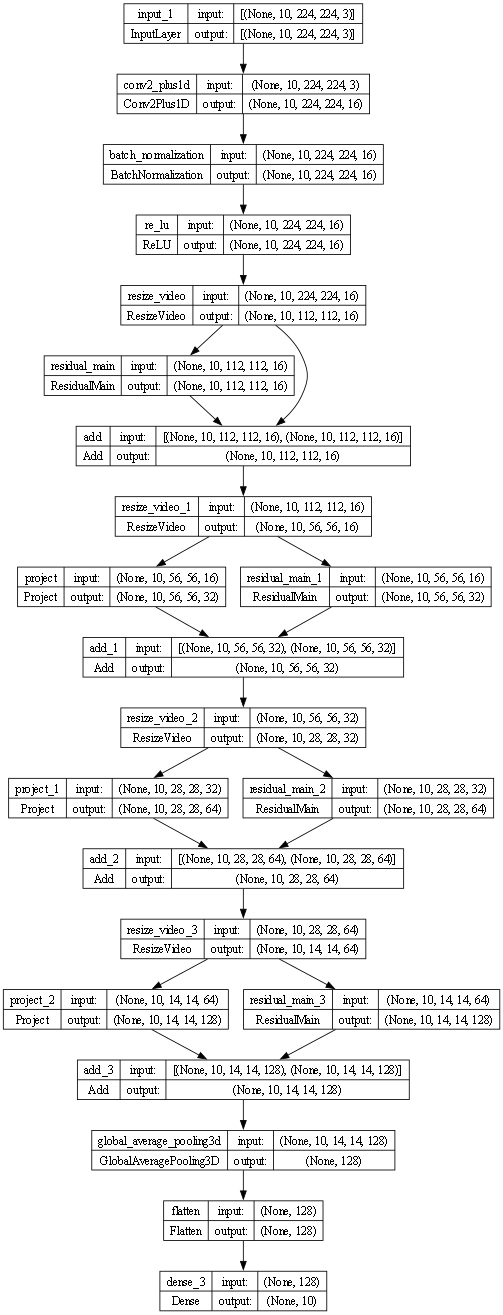

In [15]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True, to_file='model.png')

## Train the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the `metrics` argument to the view the accuracy of the model performance at every step.

In [16]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

Train the model for 50 epoches with the Keras `Model.fit` method.

Note: This example model is trained on fewer data points (300 training and 100 validation examples) to keep training time reasonable for this tutorial. Moreover, this example model may take over one hour to train.

In [17]:
history = model.fit(x = train_ds,
                    epochs = 50, 
                    validation_data = val_ds)

Epoch 1/50


38/38 [==============================] - 81s 2s/step - loss: 2.3668 - accuracy: 0.1633 - val_loss: 2.3057 - val_accuracy: 0.1700
Epoch 2/50
38/38 [==============================] - 73s 2s/step - loss: 2.1664 - accuracy: 0.2067 - val_loss: 2.6912 - val_accuracy: 0.1000
Epoch 3/50
38/38 [==============================] - 74s 2s/step - loss: 2.0668 - accuracy: 0.2400 - val_loss: 2.6114 - val_accuracy: 0.1400
Epoch 4/50
38/38 [==============================] - 74s 2s/step - loss: 1.9720 - accuracy: 0.2900 - val_loss: 2.1216 - val_accuracy: 0.2200
Epoch 5/50
38/38 [==============================] - 73s 2s/step - loss: 1.7840 - accuracy: 0.3667 - val_loss: 2.4299 - val_accuracy: 0.1900
Epoch 6/50
38/38 [==============================] - 75s 2s/step - loss: 1.8783 - accuracy: 0.3033 - val_loss: 2.3862 - val_accuracy: 0.2200
Epoch 7/50
38/38 [==============================] - 76s 2s/step - loss: 1.7098 - accuracy: 0.3433 - val_loss: 1.9364 - val_accuracy: 0.3200
Epoch 8/50
38/38 [

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.3796 - loss: 1.6601

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3962 - loss: 1.6457

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4059 - loss: 1.6367

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4099 - loss: 1.6302

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4106 - loss: 1.6241

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4121 - loss: 1.6216

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4128 - loss: 1.6207

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4123 - loss: 1.6247

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4131 - loss: 1.6267

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4142 - loss: 1.6263

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4144 - loss: 1.6248

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4148 - loss: 1.6235

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4142 - loss: 1.6244

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4144 - loss: 1.6240

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4147 - loss: 1.6239

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4149 - loss: 1.6236

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4147 - loss: 1.6249

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4147 - loss: 1.6253

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4149 - loss: 1.6261

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4150 - loss: 1.6267

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4150 - loss: 1.6283

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4153 - loss: 1.6290

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4155 - loss: 1.6297

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4158 - loss: 1.6300

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4160 - loss: 1.6303 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4163 - loss: 1.6304

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4164 - loss: 1.6303

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4165 - loss: 1.6300

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4165 - loss: 1.6297

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4162 - loss: 1.6296

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4161 - loss: 1.6296

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4159 - loss: 1.6296

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4156 - loss: 1.6297

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4153 - loss: 1.6298

2024-05-01 01:33:43.760214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:33:43.760260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4150 - loss: 1.6299 - val_accuracy: 0.3200 - val_loss: 1.7989


Epoch 11/50


2024-05-01 01:33:54.480935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:33:54.480981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.3750 - loss: 1.6811

 2/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3750 - loss: 1.6565

 3/38 ━━━━━━━━━━━━━━━━━━━━ 32s 939ms/step - accuracy: 0.4306 - loss: 1.5693

 4/38 ━━━━━━━━━━━━━━━━━━━━ 33s 988ms/step - accuracy: 0.4479 - loss: 1.5529

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 996ms/step - accuracy: 0.4633 - loss: 1.5369

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4799 - loss: 1.5237   

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4904 - loss: 1.5119

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4975 - loss: 1.5088

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5039 - loss: 1.5069

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5048 - loss: 1.5159

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5074 - loss: 1.5212

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5094 - loss: 1.5263

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5102 - loss: 1.5299

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5107 - loss: 1.5329

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5106 - loss: 1.5370

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5104 - loss: 1.5396

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5102 - loss: 1.5421

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5096 - loss: 1.5447

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5084 - loss: 1.5476

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5071 - loss: 1.5510

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5053 - loss: 1.5552

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5038 - loss: 1.5588

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5027 - loss: 1.5615

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5019 - loss: 1.5632

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5010 - loss: 1.5647

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5001 - loss: 1.5661

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4992 - loss: 1.5669

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4980 - loss: 1.5688

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4969 - loss: 1.5703 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4960 - loss: 1.5714

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4953 - loss: 1.5724

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4949 - loss: 1.5734

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4943 - loss: 1.5745

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4941 - loss: 1.5752

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4939 - loss: 1.5757

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4938 - loss: 1.5761

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4936 - loss: 1.5768

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4934 - loss: 1.5774

2024-05-01 01:34:32.808397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:34:32.808440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4933 - loss: 1.5779 - val_accuracy: 0.3700 - val_loss: 1.8226


Epoch 12/50


2024-05-01 01:34:43.337667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:34:43.337736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5000 - loss: 1.5471

 2/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4688 - loss: 1.6194

 3/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4653 - loss: 1.5946

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4661 - loss: 1.5774

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4629 - loss: 1.5566

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4587 - loss: 1.5417

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4569 - loss: 1.5237

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4545 - loss: 1.5119

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4534 - loss: 1.5082

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4530 - loss: 1.5038

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4511 - loss: 1.5065

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4482 - loss: 1.5124

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4448 - loss: 1.5164

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4418 - loss: 1.5210

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4390 - loss: 1.5236

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4369 - loss: 1.5274

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4354 - loss: 1.5306

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4332 - loss: 1.5357

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4302 - loss: 1.5414

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4271 - loss: 1.5465

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4246 - loss: 1.5509

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4224 - loss: 1.5548

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4203 - loss: 1.5587

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4180 - loss: 1.5627

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4157 - loss: 1.5667

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4137 - loss: 1.5694

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4125 - loss: 1.5708

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4113 - loss: 1.5724

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4102 - loss: 1.5742 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4090 - loss: 1.5761

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4077 - loss: 1.5784

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4065 - loss: 1.5804

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4054 - loss: 1.5821

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4046 - loss: 1.5836

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4036 - loss: 1.5852

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4028 - loss: 1.5870

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4020 - loss: 1.5885

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4012 - loss: 1.5900

2024-05-01 01:35:21.715906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:35:21.715955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4005 - loss: 1.5913 - val_accuracy: 0.3100 - val_loss: 1.8618


Epoch 13/50


2024-05-01 01:35:32.314501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:35:32.314548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2500 - loss: 1.9324

 2/38 ━━━━━━━━━━━━━━━━━━━━ 33s 923ms/step - accuracy: 0.2188 - loss: 1.9166

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2292 - loss: 1.8754   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2500 - loss: 1.8380

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2750 - loss: 1.7869

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2917 - loss: 1.7505

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3036 - loss: 1.7324

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.3105 - loss: 1.7166

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3177 - loss: 1.7034

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3259 - loss: 1.6895

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3325 - loss: 1.6789

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3386 - loss: 1.6704

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3422 - loss: 1.6631

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3464 - loss: 1.6557

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3494 - loss: 1.6511

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3530 - loss: 1.6452

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3564 - loss: 1.6401

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3602 - loss: 1.6337

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3641 - loss: 1.6276

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3674 - loss: 1.6235

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3706 - loss: 1.6190

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3734 - loss: 1.6160

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3756 - loss: 1.6141

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3775 - loss: 1.6125

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3794 - loss: 1.6112

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3815 - loss: 1.6100

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3833 - loss: 1.6095

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3846 - loss: 1.6097

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3857 - loss: 1.6099 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3866 - loss: 1.6100

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3874 - loss: 1.6099

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3884 - loss: 1.6095

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3894 - loss: 1.6087

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3902 - loss: 1.6079

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3912 - loss: 1.6070

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3924 - loss: 1.6058

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3933 - loss: 1.6050

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3941 - loss: 1.6043

2024-05-01 01:36:10.851518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:36:10.851589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.3949 - loss: 1.6036 - val_accuracy: 0.4100 - val_loss: 1.7070


Epoch 14/50


2024-05-01 01:36:21.246493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:36:21.246540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7500 - loss: 1.1798

 2/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6562 - loss: 1.2687

 3/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6042 - loss: 1.3505

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5625 - loss: 1.3952

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5400 - loss: 1.4138

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5229 - loss: 1.4185

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5145 - loss: 1.4170

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5049 - loss: 1.4253

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4982 - loss: 1.4279

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4909 - loss: 1.4322

11/38 ━━━━━━━━━━━━━━━━━━━━ 26s 999ms/step - accuracy: 0.4855 - loss: 1.4331

12/38 ━━━━━━━━━━━━━━━━━━━━ 25s 989ms/step - accuracy: 0.4815 - loss: 1.4323

13/38 ━━━━━━━━━━━━━━━━━━━━ 24s 991ms/step - accuracy: 0.4770 - loss: 1.4341

14/38 ━━━━━━━━━━━━━━━━━━━━ 23s 992ms/step - accuracy: 0.4735 - loss: 1.4350

15/38 ━━━━━━━━━━━━━━━━━━━━ 22s 999ms/step - accuracy: 0.4698 - loss: 1.4369

16/38 ━━━━━━━━━━━━━━━━━━━━ 21s 996ms/step - accuracy: 0.4668 - loss: 1.4378

17/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1000ms/step - accuracy: 0.4640 - loss: 1.4388

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4617 - loss: 1.4399    

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4599 - loss: 1.4407

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4585 - loss: 1.4413

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4574 - loss: 1.4418

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4562 - loss: 1.4421

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4546 - loss: 1.4443

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4532 - loss: 1.4465

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4521 - loss: 1.4486

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4513 - loss: 1.4501

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4505 - loss: 1.4514

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4502 - loss: 1.4526

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4503 - loss: 1.4530 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4506 - loss: 1.4534

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4510 - loss: 1.4533

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4514 - loss: 1.4529

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4518 - loss: 1.4525

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4520 - loss: 1.4523

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4522 - loss: 1.4522

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4526 - loss: 1.4519

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4529 - loss: 1.4519

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.4531 - loss: 1.4518

2024-05-01 01:36:59.594407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:36:59.594453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4532 - loss: 1.4517 - val_accuracy: 0.4500 - val_loss: 1.4516


Epoch 15/50


2024-05-01 01:37:10.225323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:37:10.225368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5000 - loss: 1.3133

 2/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5312 - loss: 1.3179

 3/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5486 - loss: 1.2730

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5443 - loss: 1.2701

 5/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5354 - loss: 1.2666

 6/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5226 - loss: 1.2691

 7/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5142 - loss: 1.2723

 8/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5066 - loss: 1.2734

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5028 - loss: 1.2745

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4988 - loss: 1.2767

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4947 - loss: 1.2827

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4900 - loss: 1.2902

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4856 - loss: 1.2962

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4815 - loss: 1.3053

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4772 - loss: 1.3131

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4742 - loss: 1.3197

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4718 - loss: 1.3247

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4703 - loss: 1.3282

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4688 - loss: 1.3320

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4672 - loss: 1.3354

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4668 - loss: 1.3374

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4660 - loss: 1.3396

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4658 - loss: 1.3416

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4661 - loss: 1.3431

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4659 - loss: 1.3450

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4655 - loss: 1.3465

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4654 - loss: 1.3479

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4649 - loss: 1.3498

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4645 - loss: 1.3513 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4643 - loss: 1.3531

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4641 - loss: 1.3545

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4643 - loss: 1.3556

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4644 - loss: 1.3568

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4645 - loss: 1.3580

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4647 - loss: 1.3592

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4650 - loss: 1.3601

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4655 - loss: 1.3608

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4660 - loss: 1.3619

2024-05-01 01:37:48.586639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:37:48.586684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4664 - loss: 1.3629 - val_accuracy: 0.3700 - val_loss: 1.7023


Epoch 16/50


2024-05-01 01:37:59.236730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:37:59.236778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6250 - loss: 1.2222

 2/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6875 - loss: 1.0961

 3/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6806 - loss: 1.1059

 4/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6432 - loss: 1.1791

 5/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6146 - loss: 1.2185

 6/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6059 - loss: 1.2361

 7/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6010 - loss: 1.2500

 8/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5923 - loss: 1.2624

 9/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5836 - loss: 1.2750

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5764 - loss: 1.2846

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5747 - loss: 1.2881

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5754 - loss: 1.2893

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5762 - loss: 1.2906

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5765 - loss: 1.2922

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5753 - loss: 1.2953

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5735 - loss: 1.2986

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5718 - loss: 1.3011

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5698 - loss: 1.3029

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5682 - loss: 1.3032

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5654 - loss: 1.3053

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5623 - loss: 1.3072

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5592 - loss: 1.3088

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5561 - loss: 1.3109

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5531 - loss: 1.3132

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5500 - loss: 1.3160

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5472 - loss: 1.3185

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5447 - loss: 1.3206

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5427 - loss: 1.3220

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5410 - loss: 1.3229 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5397 - loss: 1.3236

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5383 - loss: 1.3245

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5368 - loss: 1.3255

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5356 - loss: 1.3261

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5345 - loss: 1.3264

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5337 - loss: 1.3267

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5328 - loss: 1.3271

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5320 - loss: 1.3274

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5312 - loss: 1.3279

2024-05-01 01:38:37.677649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:38:37.677697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5304 - loss: 1.3284 - val_accuracy: 0.4900 - val_loss: 1.5107


Epoch 17/50


2024-05-01 01:38:48.321021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:38:48.321070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2500 - loss: 1.4348

 2/38 ━━━━━━━━━━━━━━━━━━━━ 35s 999ms/step - accuracy: 0.3438 - loss: 1.2907

 3/38 ━━━━━━━━━━━━━━━━━━━━ 34s 996ms/step - accuracy: 0.3681 - loss: 1.2209

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3698 - loss: 1.2092   

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3658 - loss: 1.2192

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3639 - loss: 1.2252

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3629 - loss: 1.2424

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.3644 - loss: 1.2544

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3672 - loss: 1.2653

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3717 - loss: 1.2743

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3772 - loss: 1.2790

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3822 - loss: 1.2815

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3861 - loss: 1.2839

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3891 - loss: 1.2867

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3921 - loss: 1.2901

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3968 - loss: 1.2902

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4012 - loss: 1.2904

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4051 - loss: 1.2910

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4091 - loss: 1.2915

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4124 - loss: 1.2917

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4151 - loss: 1.2920

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4185 - loss: 1.2913

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4213 - loss: 1.2918

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4239 - loss: 1.2923

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4264 - loss: 1.2927

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4288 - loss: 1.2926

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4310 - loss: 1.2928

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4331 - loss: 1.2924

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4350 - loss: 1.2921 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4371 - loss: 1.2913

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4392 - loss: 1.2905

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4411 - loss: 1.2897

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4427 - loss: 1.2892

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4441 - loss: 1.2892

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4455 - loss: 1.2891

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4469 - loss: 1.2889

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4483 - loss: 1.2885

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4497 - loss: 1.2881

2024-05-01 01:39:26.796215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:39:26.796261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4510 - loss: 1.2877 - val_accuracy: 0.3800 - val_loss: 1.7984


Epoch 18/50


2024-05-01 01:39:37.124835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:39:37.124880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6250 - loss: 1.0942

 2/38 ━━━━━━━━━━━━━━━━━━━━ 35s 972ms/step - accuracy: 0.5938 - loss: 1.1306

 3/38 ━━━━━━━━━━━━━━━━━━━━ 33s 966ms/step - accuracy: 0.5764 - loss: 1.1936

 4/38 ━━━━━━━━━━━━━━━━━━━━ 32s 962ms/step - accuracy: 0.5729 - loss: 1.2109

 5/38 ━━━━━━━━━━━━━━━━━━━━ 30s 936ms/step - accuracy: 0.5683 - loss: 1.2207

 6/38 ━━━━━━━━━━━━━━━━━━━━ 30s 962ms/step - accuracy: 0.5604 - loss: 1.2345

 7/38 ━━━━━━━━━━━━━━━━━━━━ 29s 963ms/step - accuracy: 0.5518 - loss: 1.2464

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 974ms/step - accuracy: 0.5473 - loss: 1.2539

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 977ms/step - accuracy: 0.5451 - loss: 1.2562

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 994ms/step - accuracy: 0.5456 - loss: 1.2554

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5445 - loss: 1.2558   

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5443 - loss: 1.2555

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5446 - loss: 1.2554

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5452 - loss: 1.2547

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5467 - loss: 1.2523

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5477 - loss: 1.2507

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5479 - loss: 1.2497

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5479 - loss: 1.2493

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5468 - loss: 1.2510

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5457 - loss: 1.2519

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5447 - loss: 1.2522

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5439 - loss: 1.2522

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5437 - loss: 1.2517

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5440 - loss: 1.2502

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5446 - loss: 1.2482

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5453 - loss: 1.2465

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5457 - loss: 1.2452

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5463 - loss: 1.2441

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5472 - loss: 1.2426 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5482 - loss: 1.2412

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5487 - loss: 1.2405

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5489 - loss: 1.2402

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5492 - loss: 1.2395

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5495 - loss: 1.2390

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5496 - loss: 1.2385

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5498 - loss: 1.2378

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5499 - loss: 1.2370

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5500 - loss: 1.2364

2024-05-01 01:40:15.844887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:40:15.844941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5501 - loss: 1.2358 - val_accuracy: 0.4600 - val_loss: 1.5495


Epoch 19/50


2024-05-01 01:40:26.381759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:40:26.381803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6250 - loss: 0.9184

 2/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5625 - loss: 1.0520

 3/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5417 - loss: 1.1079

 4/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5234 - loss: 1.1377

 5/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5138 - loss: 1.1544

 6/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5149 - loss: 1.1668

 7/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5153 - loss: 1.1810

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5173 - loss: 1.1899

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5170 - loss: 1.1959

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5190 - loss: 1.1984

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5224 - loss: 1.1982

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5258 - loss: 1.1978

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5290 - loss: 1.1963

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5333 - loss: 1.1925

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5372 - loss: 1.1886

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5412 - loss: 1.1856

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5453 - loss: 1.1822

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5482 - loss: 1.1791

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5505 - loss: 1.1765

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5523 - loss: 1.1744

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5541 - loss: 1.1734

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5555 - loss: 1.1715

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5569 - loss: 1.1700

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5582 - loss: 1.1691

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5593 - loss: 1.1676

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5605 - loss: 1.1662

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5613 - loss: 1.1651

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5617 - loss: 1.1650

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5618 - loss: 1.1655 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5613 - loss: 1.1669

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5608 - loss: 1.1681

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5604 - loss: 1.1693

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5602 - loss: 1.1704

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5599 - loss: 1.1713

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5599 - loss: 1.1718

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5599 - loss: 1.1724

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5598 - loss: 1.1731

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5596 - loss: 1.1740

2024-05-01 01:41:04.819809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:41:04.819851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5594 - loss: 1.1749 - val_accuracy: 0.5800 - val_loss: 1.2670


Epoch 20/50


2024-05-01 01:41:15.465625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:41:15.465670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5000 - loss: 0.9464

 2/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5625 - loss: 0.9215

 3/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6111 - loss: 0.8940

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6224 - loss: 0.9440

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6179 - loss: 0.9756

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6087 - loss: 1.0012

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6008 - loss: 1.0211

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5960 - loss: 1.0335

 9/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5946 - loss: 1.0404

10/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5951 - loss: 1.0442

11/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5968 - loss: 1.0443

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5992 - loss: 1.0445

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6004 - loss: 1.0461

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6009 - loss: 1.0503

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6003 - loss: 1.0579

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5994 - loss: 1.0642

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5983 - loss: 1.0707

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5975 - loss: 1.0762

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5975 - loss: 1.0797

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5977 - loss: 1.0823

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5981 - loss: 1.0837

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5983 - loss: 1.0850

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5988 - loss: 1.0858

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5992 - loss: 1.0870

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5996 - loss: 1.0877

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6000 - loss: 1.0887

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6001 - loss: 1.0900

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6002 - loss: 1.0914

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6003 - loss: 1.0929 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6002 - loss: 1.0952

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5999 - loss: 1.0975

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5997 - loss: 1.0997

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5995 - loss: 1.1022

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5992 - loss: 1.1045

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5992 - loss: 1.1063

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5989 - loss: 1.1081

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5988 - loss: 1.1094

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5987 - loss: 1.1106

2024-05-01 01:41:54.198335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:41:54.198381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5985 - loss: 1.1117 - val_accuracy: 0.3400 - val_loss: 2.2354


Epoch 21/50


2024-05-01 01:42:04.762144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:42:04.762188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6250 - loss: 1.0834

 2/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5312 - loss: 1.2212

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5486 - loss: 1.2268

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5755 - loss: 1.2198

 5/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5954 - loss: 1.2013

 6/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6142 - loss: 1.1806

 7/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6285 - loss: 1.1692

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6320 - loss: 1.1668

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6374 - loss: 1.1607

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6399 - loss: 1.1591

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6416 - loss: 1.1562

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6411 - loss: 1.1547

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6391 - loss: 1.1547

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6388 - loss: 1.1532

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6384 - loss: 1.1515

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6381 - loss: 1.1494

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6373 - loss: 1.1480

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6362 - loss: 1.1465

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6346 - loss: 1.1458

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6332 - loss: 1.1453

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6314 - loss: 1.1457

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6298 - loss: 1.1457

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6279 - loss: 1.1453

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6256 - loss: 1.1468

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6240 - loss: 1.1473

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6226 - loss: 1.1480

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6211 - loss: 1.1488

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6198 - loss: 1.1495

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6181 - loss: 1.1509 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6165 - loss: 1.1522

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6148 - loss: 1.1542

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6132 - loss: 1.1562

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6117 - loss: 1.1577

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6104 - loss: 1.1589

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6090 - loss: 1.1600

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6076 - loss: 1.1612

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6060 - loss: 1.1627

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6045 - loss: 1.1643

2024-05-01 01:42:43.206237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:42:43.206282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6031 - loss: 1.1657 - val_accuracy: 0.4700 - val_loss: 1.5135


Epoch 22/50


2024-05-01 01:42:53.906904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:42:53.906955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7500 - loss: 0.8619

 2/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7188 - loss: 0.9603

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7431 - loss: 0.9308

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7370 - loss: 0.9241

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7396 - loss: 0.9033

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7448 - loss: 0.8826

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7404 - loss: 0.8722

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7358 - loss: 0.8673

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 993ms/step - accuracy: 0.7281 - loss: 0.8725

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 999ms/step - accuracy: 0.7203 - loss: 0.8767

11/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1000ms/step - accuracy: 0.7137 - loss: 0.8822

12/38 ━━━━━━━━━━━━━━━━━━━━ 25s 996ms/step - accuracy: 0.7072 - loss: 0.8888 

13/38 ━━━━━━━━━━━━━━━━━━━━ 24s 988ms/step - accuracy: 0.7031 - loss: 0.8932

14/38 ━━━━━━━━━━━━━━━━━━━━ 23s 987ms/step - accuracy: 0.7000 - loss: 0.8976

15/38 ━━━━━━━━━━━━━━━━━━━━ 22s 993ms/step - accuracy: 0.6967 - loss: 0.9049

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6927 - loss: 0.9129   

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6892 - loss: 0.9198

18/38 ━━━━━━━━━━━━━━━━━━━━ 19s 994ms/step - accuracy: 0.6868 - loss: 0.9251

19/38 ━━━━━━━━━━━━━━━━━━━━ 18s 994ms/step - accuracy: 0.6845 - loss: 0.9297

20/38 ━━━━━━━━━━━━━━━━━━━━ 17s 991ms/step - accuracy: 0.6828 - loss: 0.9332

21/38 ━━━━━━━━━━━━━━━━━━━━ 16s 991ms/step - accuracy: 0.6812 - loss: 0.9361

22/38 ━━━━━━━━━━━━━━━━━━━━ 15s 988ms/step - accuracy: 0.6784 - loss: 0.9412

23/38 ━━━━━━━━━━━━━━━━━━━━ 14s 993ms/step - accuracy: 0.6754 - loss: 0.9467

24/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1000ms/step - accuracy: 0.6724 - loss: 0.9513

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6693 - loss: 0.9561    

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6661 - loss: 0.9603

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6630 - loss: 0.9641

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6602 - loss: 0.9681

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6578 - loss: 0.9714 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6552 - loss: 0.9758

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6528 - loss: 0.9799

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6507 - loss: 0.9837

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6488 - loss: 0.9874

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6469 - loss: 0.9908

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6453 - loss: 0.9940

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6437 - loss: 0.9968

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6423 - loss: 0.9993

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.6409 - loss: 1.0018

2024-05-01 01:43:32.004066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:43:32.004113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6396 - loss: 1.0041 - val_accuracy: 0.4500 - val_loss: 1.5741


Epoch 23/50


2024-05-01 01:43:42.633894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:43:42.633944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3750 - loss: 1.3683

 2/38 ━━━━━━━━━━━━━━━━━━━━ 34s 962ms/step - accuracy: 0.4375 - loss: 1.2967

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4861 - loss: 1.2219   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4974 - loss: 1.2015

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5079 - loss: 1.1800

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5205 - loss: 1.1619

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5252 - loss: 1.1510

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5240 - loss: 1.1545

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5275 - loss: 1.1486

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5310 - loss: 1.1430

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5344 - loss: 1.1383

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5385 - loss: 1.1331

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5422 - loss: 1.1285

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5449 - loss: 1.1246

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5480 - loss: 1.1221

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5504 - loss: 1.1203

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5526 - loss: 1.1179

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5547 - loss: 1.1150

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5563 - loss: 1.1125

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5576 - loss: 1.1112

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5585 - loss: 1.1102

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5597 - loss: 1.1096

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5614 - loss: 1.1086

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5623 - loss: 1.1097

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5628 - loss: 1.1111

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5628 - loss: 1.1127

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5632 - loss: 1.1133

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5638 - loss: 1.1141

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5643 - loss: 1.1147 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5648 - loss: 1.1158

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5653 - loss: 1.1167

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5657 - loss: 1.1176

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5662 - loss: 1.1181

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5668 - loss: 1.1183

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5671 - loss: 1.1188

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5675 - loss: 1.1193

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5677 - loss: 1.1201

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5682 - loss: 1.1207

2024-05-01 01:44:20.962551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:44:20.962597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5685 - loss: 1.1212 - val_accuracy: 0.5300 - val_loss: 1.2757


Epoch 24/50


2024-05-01 01:44:31.614889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:44:31.614936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6250 - loss: 1.1377

 2/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6250 - loss: 1.1260

 3/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6250 - loss: 1.0997

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6250 - loss: 1.0894

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6200 - loss: 1.0946

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6278 - loss: 1.0793

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6376 - loss: 1.0578

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6419 - loss: 1.0444

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6431 - loss: 1.0421

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6463 - loss: 1.0373

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6454 - loss: 1.0351

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6437 - loss: 1.0354

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6400 - loss: 1.0400

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6358 - loss: 1.0481

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6323 - loss: 1.0556

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6289 - loss: 1.0637

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6265 - loss: 1.0710

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6241 - loss: 1.0778

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6217 - loss: 1.0839

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6194 - loss: 1.0898

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6177 - loss: 1.0940

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6162 - loss: 1.0971

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6147 - loss: 1.0999

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6136 - loss: 1.1023

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6128 - loss: 1.1040

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6122 - loss: 1.1051

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6118 - loss: 1.1054

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6117 - loss: 1.1052

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6115 - loss: 1.1049 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6116 - loss: 1.1043

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6115 - loss: 1.1036

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6113 - loss: 1.1038

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6110 - loss: 1.1042

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6108 - loss: 1.1043

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6105 - loss: 1.1046

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6105 - loss: 1.1042

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6103 - loss: 1.1039

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1000ms/step - accuracy: 0.6101 - loss: 1.1038

2024-05-01 01:45:09.790791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:45:09.790834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6100 - loss: 1.1037 - val_accuracy: 0.4800 - val_loss: 1.4255


Epoch 25/50


2024-05-01 01:45:20.174585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:45:20.174631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3750 - loss: 1.2319

 2/38 ━━━━━━━━━━━━━━━━━━━━ 35s 996ms/step - accuracy: 0.5000 - loss: 1.0880

 3/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5694 - loss: 0.9937   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 33s 974ms/step - accuracy: 0.6068 - loss: 0.9578

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6204 - loss: 0.9522   

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6247 - loss: 0.9602

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6273 - loss: 0.9687

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 998ms/step - accuracy: 0.6309 - loss: 0.9716

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 998ms/step - accuracy: 0.6333 - loss: 0.9786

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6362 - loss: 0.9836   

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6383 - loss: 0.9869

12/38 ━━━━━━━━━━━━━━━━━━━━ 25s 998ms/step - accuracy: 0.6415 - loss: 0.9869

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6440 - loss: 0.9865   

14/38 ━━━━━━━━━━━━━━━━━━━━ 23s 997ms/step - accuracy: 0.6471 - loss: 0.9848

15/38 ━━━━━━━━━━━━━━━━━━━━ 22s 996ms/step - accuracy: 0.6484 - loss: 0.9840

16/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1000ms/step - accuracy: 0.6498 - loss: 0.9817

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6514 - loss: 0.9790    

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6519 - loss: 0.9778

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6518 - loss: 0.9773

20/38 ━━━━━━━━━━━━━━━━━━━━ 17s 994ms/step - accuracy: 0.6518 - loss: 0.9764

21/38 ━━━━━━━━━━━━━━━━━━━━ 16s 998ms/step - accuracy: 0.6519 - loss: 0.9753

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6520 - loss: 0.9750   

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6522 - loss: 0.9749

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6522 - loss: 0.9754

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6525 - loss: 0.9754

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6531 - loss: 0.9749

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6532 - loss: 0.9752

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6532 - loss: 0.9758

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6528 - loss: 0.9767 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6522 - loss: 0.9774

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6513 - loss: 0.9785

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6502 - loss: 0.9799

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6493 - loss: 0.9808

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6484 - loss: 0.9816

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6475 - loss: 0.9824

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6468 - loss: 0.9830

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6460 - loss: 0.9838

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6454 - loss: 0.9844

2024-05-01 01:45:58.413810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:45:58.413855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6447 - loss: 0.9850 - val_accuracy: 0.6100 - val_loss: 1.1376


Epoch 26/50


2024-05-01 01:46:08.848147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:46:08.848192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7500 - loss: 0.7266

 2/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8125 - loss: 0.6845

 3/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8194 - loss: 0.7116

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8099 - loss: 0.7471

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8029 - loss: 0.7790

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7976 - loss: 0.8005

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7882 - loss: 0.8189

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7815 - loss: 0.8315

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7734 - loss: 0.8414

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7698 - loss: 0.8461

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7680 - loss: 0.8485

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7656 - loss: 0.8519

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7629 - loss: 0.8578

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7588 - loss: 0.8659

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7549 - loss: 0.8735

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7517 - loss: 0.8814

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7490 - loss: 0.8874

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7467 - loss: 0.8924

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7438 - loss: 0.8979

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7410 - loss: 0.9024

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7388 - loss: 0.9058

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7368 - loss: 0.9084

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7350 - loss: 0.9100

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7332 - loss: 0.9115

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7317 - loss: 0.9127

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7305 - loss: 0.9132

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7295 - loss: 0.9135

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7290 - loss: 0.9133

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7282 - loss: 0.9131 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7272 - loss: 0.9129

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7263 - loss: 0.9124

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7256 - loss: 0.9117

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7249 - loss: 0.9111

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7241 - loss: 0.9106

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7233 - loss: 0.9101

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7224 - loss: 0.9100

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7215 - loss: 0.9096

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7205 - loss: 0.9094

2024-05-01 01:46:47.418722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:46:47.418778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7195 - loss: 0.9091 - val_accuracy: 0.5600 - val_loss: 1.1900


Epoch 27/50


2024-05-01 01:46:57.750561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:46:57.750626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7500 - loss: 0.5892

 2/38 ━━━━━━━━━━━━━━━━━━━━ 32s 895ms/step - accuracy: 0.6562 - loss: 0.7202

 3/38 ━━━━━━━━━━━━━━━━━━━━ 33s 964ms/step - accuracy: 0.6042 - loss: 0.7890

 4/38 ━━━━━━━━━━━━━━━━━━━━ 33s 993ms/step - accuracy: 0.5625 - loss: 0.8454

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5400 - loss: 0.8794   

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5299 - loss: 0.9039

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5256 - loss: 0.9194

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5263 - loss: 0.9241

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5311 - loss: 0.9244

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5355 - loss: 0.9255

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5405 - loss: 0.9273

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5450 - loss: 0.9291

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5489 - loss: 0.9302

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5524 - loss: 0.9310

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5556 - loss: 0.9317

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5585 - loss: 0.9345

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5606 - loss: 0.9374

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5631 - loss: 0.9405

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5653 - loss: 0.9430

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5676 - loss: 0.9449

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5704 - loss: 0.9460

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5726 - loss: 0.9473

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5742 - loss: 0.9501

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5756 - loss: 0.9525

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5768 - loss: 0.9547

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5781 - loss: 0.9561

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5793 - loss: 0.9570

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5806 - loss: 0.9576

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5819 - loss: 0.9586 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5829 - loss: 0.9594

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5841 - loss: 0.9596

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5853 - loss: 0.9597

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5864 - loss: 0.9599

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5874 - loss: 0.9601

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5885 - loss: 0.9601

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5896 - loss: 0.9601

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5906 - loss: 0.9601

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5917 - loss: 0.9600

2024-05-01 01:47:36.069689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:47:36.069734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5927 - loss: 0.9599 - val_accuracy: 0.5800 - val_loss: 1.3921


Epoch 28/50


2024-05-01 01:47:46.426764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:47:46.426825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5000 - loss: 1.0670

 2/38 ━━━━━━━━━━━━━━━━━━━━ 35s 975ms/step - accuracy: 0.5000 - loss: 1.0813

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5139 - loss: 1.0719   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5339 - loss: 1.0363

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 987ms/step - accuracy: 0.5521 - loss: 1.0192

 6/38 ━━━━━━━━━━━━━━━━━━━━ 31s 999ms/step - accuracy: 0.5642 - loss: 1.0192

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5755 - loss: 1.0092   

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5856 - loss: 1.0041

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5915 - loss: 1.0050

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5973 - loss: 1.0023

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6030 - loss: 0.9987

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6074 - loss: 0.9948

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6117 - loss: 0.9905

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6139 - loss: 0.9892

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6158 - loss: 0.9875

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6183 - loss: 0.9848

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6200 - loss: 0.9837

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6211 - loss: 0.9826

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6220 - loss: 0.9817

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6237 - loss: 0.9795

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6257 - loss: 0.9764

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6275 - loss: 0.9737

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6293 - loss: 0.9712

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6306 - loss: 0.9689

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6320 - loss: 0.9669

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6328 - loss: 0.9655

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6337 - loss: 0.9639

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6345 - loss: 0.9628

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6356 - loss: 0.9613 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6363 - loss: 0.9601

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6370 - loss: 0.9588

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6373 - loss: 0.9581

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6377 - loss: 0.9575

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6379 - loss: 0.9571

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6381 - loss: 0.9568

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6382 - loss: 0.9565

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6384 - loss: 0.9561

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6385 - loss: 0.9558

2024-05-01 01:48:24.688769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:48:24.688815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6386 - loss: 0.9555 - val_accuracy: 0.5700 - val_loss: 1.1771


Epoch 29/50


2024-05-01 01:48:35.205715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:48:35.205756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7500 - loss: 0.5994

 2/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7188 - loss: 0.6050

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7014 - loss: 0.6407

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6979 - loss: 0.6843

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6983 - loss: 0.7050

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7000 - loss: 0.7186

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6969 - loss: 0.7359

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6938 - loss: 0.7489

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6923 - loss: 0.7608

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6919 - loss: 0.7716

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6899 - loss: 0.7832

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6897 - loss: 0.7915

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6892 - loss: 0.7997

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6878 - loss: 0.8089

15/38 ━━━━━━━━━━━━━━━━━━━━ 22s 999ms/step - accuracy: 0.6864 - loss: 0.8193

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6855 - loss: 0.8270   

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6849 - loss: 0.8326

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6839 - loss: 0.8389

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6829 - loss: 0.8441

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6822 - loss: 0.8484

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6806 - loss: 0.8536

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6791 - loss: 0.8587

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6782 - loss: 0.8628

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6773 - loss: 0.8668

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6762 - loss: 0.8715

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6746 - loss: 0.8773

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6726 - loss: 0.8828

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6707 - loss: 0.8877

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6693 - loss: 0.8919 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6681 - loss: 0.8955

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6671 - loss: 0.8986

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6661 - loss: 0.9013

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6651 - loss: 0.9039

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6643 - loss: 0.9061

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6635 - loss: 0.9078

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6628 - loss: 0.9095

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6620 - loss: 0.9110

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6613 - loss: 0.9125

2024-05-01 01:49:13.881434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:49:13.881492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6605 - loss: 0.9139 - val_accuracy: 0.5900 - val_loss: 1.1538


Epoch 30/50


2024-05-01 01:49:24.385718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:49:24.385782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5000 - loss: 1.1858

 2/38 ━━━━━━━━━━━━━━━━━━━━ 35s 995ms/step - accuracy: 0.4375 - loss: 1.2527

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4444 - loss: 1.2713   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4505 - loss: 1.2468

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4704 - loss: 1.2085

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4927 - loss: 1.1670

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5040 - loss: 1.1453

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5152 - loss: 1.1270

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5228 - loss: 1.1133

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5292 - loss: 1.1020

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5369 - loss: 1.0891

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5408 - loss: 1.0817

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5450 - loss: 1.0736

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5507 - loss: 1.0651

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5568 - loss: 1.0558

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5620 - loss: 1.0478

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5666 - loss: 1.0419

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5710 - loss: 1.0359

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5749 - loss: 1.0301

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5790 - loss: 1.0244

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5826 - loss: 1.0188

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5855 - loss: 1.0136

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5887 - loss: 1.0082

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5917 - loss: 1.0028

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5946 - loss: 0.9978

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5969 - loss: 0.9934

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5985 - loss: 0.9900

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6000 - loss: 0.9871

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6018 - loss: 0.9842 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6033 - loss: 0.9814

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6047 - loss: 0.9784

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6064 - loss: 0.9758

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6077 - loss: 0.9733

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6092 - loss: 0.9708

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6107 - loss: 0.9681

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6118 - loss: 0.9657

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6128 - loss: 0.9638

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6138 - loss: 0.9618

2024-05-01 01:50:02.737167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:50:02.737225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6147 - loss: 0.9599 - val_accuracy: 0.5900 - val_loss: 1.1690


Epoch 31/50


2024-05-01 01:50:13.225610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:50:13.225665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6250 - loss: 0.9712

 2/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6250 - loss: 0.9754

 3/38 ━━━━━━━━━━━━━━━━━━━━ 34s 987ms/step - accuracy: 0.6389 - loss: 0.9337

 4/38 ━━━━━━━━━━━━━━━━━━━━ 32s 966ms/step - accuracy: 0.6354 - loss: 0.9149

 5/38 ━━━━━━━━━━━━━━━━━━━━ 31s 959ms/step - accuracy: 0.6433 - loss: 0.9065

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6438 - loss: 0.8975   

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6436 - loss: 0.8930

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6491 - loss: 0.8828

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6480 - loss: 0.8796

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6469 - loss: 0.8785

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6480 - loss: 0.8751

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6513 - loss: 0.8695

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6545 - loss: 0.8647

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6562 - loss: 0.8619

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6574 - loss: 0.8595

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6583 - loss: 0.8575

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6590 - loss: 0.8559

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6606 - loss: 0.8530

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6618 - loss: 0.8502

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6631 - loss: 0.8476

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6647 - loss: 0.8449

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6662 - loss: 0.8426

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6680 - loss: 0.8404

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6697 - loss: 0.8384

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6713 - loss: 0.8367

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6726 - loss: 0.8352

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6738 - loss: 0.8342

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6749 - loss: 0.8329

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6759 - loss: 0.8317 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6765 - loss: 0.8308

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6768 - loss: 0.8303

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6770 - loss: 0.8301

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6768 - loss: 0.8309

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6769 - loss: 0.8311

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6770 - loss: 0.8315

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6770 - loss: 0.8319

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6770 - loss: 0.8322

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6770 - loss: 0.8324

2024-05-01 01:50:51.610035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:50:51.610079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6771 - loss: 0.8325 - val_accuracy: 0.6000 - val_loss: 1.0798


Epoch 32/50


2024-05-01 01:51:01.933931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:51:01.933998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7500 - loss: 0.7057

 2/38 ━━━━━━━━━━━━━━━━━━━━ 35s 985ms/step - accuracy: 0.7500 - loss: 0.7270

 3/38 ━━━━━━━━━━━━━━━━━━━━ 34s 997ms/step - accuracy: 0.7361 - loss: 0.7852

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7240 - loss: 0.8181   

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7242 - loss: 0.8263

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7250 - loss: 0.8295

 7/38 ━━━━━━━━━━━━━━━━━━━━ 30s 993ms/step - accuracy: 0.7260 - loss: 0.8292

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7271 - loss: 0.8243   

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 991ms/step - accuracy: 0.7296 - loss: 0.8171

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 991ms/step - accuracy: 0.7317 - loss: 0.8116

11/38 ━━━━━━━━━━━━━━━━━━━━ 26s 986ms/step - accuracy: 0.7354 - loss: 0.8039

12/38 ━━━━━━━━━━━━━━━━━━━━ 25s 986ms/step - accuracy: 0.7392 - loss: 0.7960

13/38 ━━━━━━━━━━━━━━━━━━━━ 24s 980ms/step - accuracy: 0.7415 - loss: 0.7912

14/38 ━━━━━━━━━━━━━━━━━━━━ 23s 986ms/step - accuracy: 0.7428 - loss: 0.7876

15/38 ━━━━━━━━━━━━━━━━━━━━ 22s 998ms/step - accuracy: 0.7438 - loss: 0.7845

16/38 ━━━━━━━━━━━━━━━━━━━━ 21s 999ms/step - accuracy: 0.7447 - loss: 0.7833

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7441 - loss: 0.7849   

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7441 - loss: 0.7854

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7440 - loss: 0.7855

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7443 - loss: 0.7851

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7446 - loss: 0.7845

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7454 - loss: 0.7835

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7463 - loss: 0.7829

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7473 - loss: 0.7820

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7476 - loss: 0.7822

26/38 ━━━━━━━━━━━━━━━━━━━━ 11s 998ms/step - accuracy: 0.7477 - loss: 0.7825

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7478 - loss: 0.7826   

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7475 - loss: 0.7829

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7472 - loss: 0.7832 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7467 - loss: 0.7838

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7464 - loss: 0.7841

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7463 - loss: 0.7840

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7461 - loss: 0.7840

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7458 - loss: 0.7842

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7454 - loss: 0.7849

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7449 - loss: 0.7856

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7445 - loss: 0.7861

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7442 - loss: 0.7864

2024-05-01 01:51:40.269265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:51:40.269319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7439 - loss: 0.7868 - val_accuracy: 0.5300 - val_loss: 1.3041


Epoch 33/50


2024-05-01 01:51:50.855654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:51:50.855699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6250 - loss: 0.8580

 2/38 ━━━━━━━━━━━━━━━━━━━━ 34s 972ms/step - accuracy: 0.5938 - loss: 0.8832

 3/38 ━━━━━━━━━━━━━━━━━━━━ 34s 977ms/step - accuracy: 0.6319 - loss: 0.8306

 4/38 ━━━━━━━━━━━━━━━━━━━━ 33s 990ms/step - accuracy: 0.6380 - loss: 0.8214

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 976ms/step - accuracy: 0.6404 - loss: 0.8287

 6/38 ━━━━━━━━━━━━━━━━━━━━ 30s 954ms/step - accuracy: 0.6448 - loss: 0.8292

 7/38 ━━━━━━━━━━━━━━━━━━━━ 29s 966ms/step - accuracy: 0.6496 - loss: 0.8271

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 982ms/step - accuracy: 0.6563 - loss: 0.8219

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6636 - loss: 0.8164   

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6698 - loss: 0.8168

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6719 - loss: 0.8234

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6741 - loss: 0.8266

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6777 - loss: 0.8272

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6797 - loss: 0.8289

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6816 - loss: 0.8308

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6834 - loss: 0.8323

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6843 - loss: 0.8355

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6852 - loss: 0.8375

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6866 - loss: 0.8387

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6882 - loss: 0.8390

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6897 - loss: 0.8390

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6917 - loss: 0.8379

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6935 - loss: 0.8366

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6952 - loss: 0.8356

25/38 ━━━━━━━━━━━━━━━━━━━━ 12s 998ms/step - accuracy: 0.6970 - loss: 0.8343

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6977 - loss: 0.8341   

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6985 - loss: 0.8346

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6989 - loss: 0.8353

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6992 - loss: 0.8360 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6992 - loss: 0.8369

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6994 - loss: 0.8376

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6994 - loss: 0.8388

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6992 - loss: 0.8403

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6993 - loss: 0.8413

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6994 - loss: 0.8422

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6997 - loss: 0.8429

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6998 - loss: 0.8435

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7000 - loss: 0.8440

2024-05-01 01:52:29.346011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:52:29.346063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7002 - loss: 0.8446 - val_accuracy: 0.5900 - val_loss: 1.0299


Epoch 34/50


2024-05-01 01:52:39.590605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:52:39.590648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6250 - loss: 0.8093

 2/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5625 - loss: 0.9104

 3/38 ━━━━━━━━━━━━━━━━━━━━ 34s 995ms/step - accuracy: 0.5833 - loss: 0.8923

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6016 - loss: 0.8774   

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6162 - loss: 0.8670

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6281 - loss: 0.8544

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6404 - loss: 0.8423

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6483 - loss: 0.8350

 9/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6549 - loss: 0.8327

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6607 - loss: 0.8292

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6668 - loss: 0.8248

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6702 - loss: 0.8254

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6719 - loss: 0.8289

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6730 - loss: 0.8311

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6737 - loss: 0.8363

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6746 - loss: 0.8405

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6756 - loss: 0.8445

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6766 - loss: 0.8468

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6784 - loss: 0.8474

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6804 - loss: 0.8473

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6829 - loss: 0.8460

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6849 - loss: 0.8452

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6861 - loss: 0.8453

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6870 - loss: 0.8463

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6877 - loss: 0.8469

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6884 - loss: 0.8472

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6890 - loss: 0.8475

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6899 - loss: 0.8471

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6908 - loss: 0.8468 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6915 - loss: 0.8462

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6924 - loss: 0.8457

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6928 - loss: 0.8457

33/38 ━━━━━━━━━━━━━━━━━━━━ 4s 998ms/step - accuracy: 0.6931 - loss: 0.8457

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6932 - loss: 0.8456   

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6934 - loss: 0.8454

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6936 - loss: 0.8452

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6938 - loss: 0.8452

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - accuracy: 0.6939 - loss: 0.8452

2024-05-01 01:53:17.561607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:53:17.561668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.6939 - loss: 0.8452 - val_accuracy: 0.4900 - val_loss: 1.3111


Epoch 35/50


2024-05-01 01:53:27.975488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:53:27.975533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7500 - loss: 1.2283

 2/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7500 - loss: 1.1456

 3/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7361 - loss: 1.1131

 4/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7396 - loss: 1.0547

 5/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7417 - loss: 1.0137

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7431 - loss: 0.9783

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7415 - loss: 0.9563

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7387 - loss: 0.9397

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7384 - loss: 0.9249

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7370 - loss: 0.9133

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7351 - loss: 0.9046

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7346 - loss: 0.8951

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7343 - loss: 0.8873

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7342 - loss: 0.8804

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7330 - loss: 0.8752

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7316 - loss: 0.8707

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7301 - loss: 0.8669

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7285 - loss: 0.8647

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7269 - loss: 0.8633

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7255 - loss: 0.8618

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7244 - loss: 0.8603

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7235 - loss: 0.8589

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7228 - loss: 0.8573

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7224 - loss: 0.8558

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7221 - loss: 0.8543

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7221 - loss: 0.8523

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7216 - loss: 0.8516

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7211 - loss: 0.8507

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7208 - loss: 0.8500 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7208 - loss: 0.8487

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7211 - loss: 0.8471

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7213 - loss: 0.8457

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7210 - loss: 0.8449

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7208 - loss: 0.8440

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7205 - loss: 0.8431

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7202 - loss: 0.8422

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7198 - loss: 0.8417

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7193 - loss: 0.8416

2024-05-01 01:54:06.554832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:54:06.554873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7188 - loss: 0.8415 - val_accuracy: 0.6000 - val_loss: 1.1907


Epoch 36/50


2024-05-01 01:54:17.081471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:54:17.081523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6250 - loss: 0.9950

 2/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6562 - loss: 0.9754

 3/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7014 - loss: 0.9041

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7214 - loss: 0.8596

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7371 - loss: 0.8342

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7392 - loss: 0.8292

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7331 - loss: 0.8359

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7313 - loss: 0.8340

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7303 - loss: 0.8289

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7310 - loss: 0.8241

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7317 - loss: 0.8193

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7332 - loss: 0.8176

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7338 - loss: 0.8152

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7337 - loss: 0.8139

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7331 - loss: 0.8122

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7327 - loss: 0.8097

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7333 - loss: 0.8059

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7330 - loss: 0.8030

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7332 - loss: 0.7997

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7335 - loss: 0.7969

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7337 - loss: 0.7938

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7339 - loss: 0.7916

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7337 - loss: 0.7904

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7337 - loss: 0.7884

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7339 - loss: 0.7863

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7340 - loss: 0.7849

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7343 - loss: 0.7830

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7343 - loss: 0.7815

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7343 - loss: 0.7806 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7344 - loss: 0.7792

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7346 - loss: 0.7776

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7347 - loss: 0.7762

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7344 - loss: 0.7756

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7340 - loss: 0.7752

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7333 - loss: 0.7750

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7327 - loss: 0.7749

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7321 - loss: 0.7747

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7316 - loss: 0.7743

2024-05-01 01:54:55.505768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:54:55.505809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7311 - loss: 0.7740 - val_accuracy: 0.6300 - val_loss: 1.0519


Epoch 37/50


2024-05-01 01:55:06.141968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:55:06.142026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8750 - loss: 0.5781

 2/38 ━━━━━━━━━━━━━━━━━━━━ 33s 931ms/step - accuracy: 0.8125 - loss: 0.6135

 3/38 ━━━━━━━━━━━━━━━━━━━━ 34s 976ms/step - accuracy: 0.7500 - loss: 0.6709

 4/38 ━━━━━━━━━━━━━━━━━━━━ 33s 992ms/step - accuracy: 0.7344 - loss: 0.6753

 5/38 ━━━━━━━━━━━━━━━━━━━━ 31s 964ms/step - accuracy: 0.7325 - loss: 0.6733

 6/38 ━━━━━━━━━━━━━━━━━━━━ 30s 959ms/step - accuracy: 0.7285 - loss: 0.6822

 7/38 ━━━━━━━━━━━━━━━━━━━━ 30s 971ms/step - accuracy: 0.7188 - loss: 0.7012

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 998ms/step - accuracy: 0.7090 - loss: 0.7169

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 990ms/step - accuracy: 0.7028 - loss: 0.7303

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 992ms/step - accuracy: 0.6950 - loss: 0.7536

11/38 ━━━━━━━━━━━━━━━━━━━━ 26s 993ms/step - accuracy: 0.6886 - loss: 0.7707

12/38 ━━━━━━━━━━━━━━━━━━━━ 25s 990ms/step - accuracy: 0.6833 - loss: 0.7871

13/38 ━━━━━━━━━━━━━━━━━━━━ 24s 999ms/step - accuracy: 0.6788 - loss: 0.8007

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6763 - loss: 0.8111   

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6745 - loss: 0.8202

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6739 - loss: 0.8267

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6736 - loss: 0.8319

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6736 - loss: 0.8360

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6735 - loss: 0.8396

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6729 - loss: 0.8432

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6729 - loss: 0.8458

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6725 - loss: 0.8483

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6726 - loss: 0.8500

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6728 - loss: 0.8515

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6725 - loss: 0.8535

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6725 - loss: 0.8549

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6728 - loss: 0.8559

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6732 - loss: 0.8566

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6734 - loss: 0.8572 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6738 - loss: 0.8575

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6740 - loss: 0.8586

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6744 - loss: 0.8592

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6748 - loss: 0.8601

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6750 - loss: 0.8613

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6754 - loss: 0.8623

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6761 - loss: 0.8628

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6765 - loss: 0.8634

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6769 - loss: 0.8639

2024-05-01 01:55:44.341043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:55:44.341085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.6772 - loss: 0.8645 - val_accuracy: 0.4500 - val_loss: 1.4352


Epoch 38/50


2024-05-01 01:55:54.641586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:55:54.641647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7500 - loss: 0.7295

 2/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7500 - loss: 0.7840

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7500 - loss: 0.7709

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7500 - loss: 0.7587

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7500 - loss: 0.7591

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7465 - loss: 0.7610

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7445 - loss: 0.7653

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 999ms/step - accuracy: 0.7432 - loss: 0.7695

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 992ms/step - accuracy: 0.7424 - loss: 0.7720

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 995ms/step - accuracy: 0.7407 - loss: 0.7742

11/38 ━━━━━━━━━━━━━━━━━━━━ 26s 999ms/step - accuracy: 0.7405 - loss: 0.7756

12/38 ━━━━━━━━━━━━━━━━━━━━ 25s 992ms/step - accuracy: 0.7413 - loss: 0.7748

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7427 - loss: 0.7735   

14/38 ━━━━━━━━━━━━━━━━━━━━ 23s 999ms/step - accuracy: 0.7451 - loss: 0.7704

15/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1000ms/step - accuracy: 0.7477 - loss: 0.7672

16/38 ━━━━━━━━━━━━━━━━━━━━ 21s 996ms/step - accuracy: 0.7498 - loss: 0.7646 

17/38 ━━━━━━━━━━━━━━━━━━━━ 20s 997ms/step - accuracy: 0.7515 - loss: 0.7629

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7518 - loss: 0.7631   

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7528 - loss: 0.7623

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7539 - loss: 0.7612

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7551 - loss: 0.7604

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7562 - loss: 0.7593

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7576 - loss: 0.7578

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7588 - loss: 0.7566

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7600 - loss: 0.7553

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7613 - loss: 0.7538

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7624 - loss: 0.7523

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7634 - loss: 0.7510

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7641 - loss: 0.7499 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7648 - loss: 0.7491

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7655 - loss: 0.7480

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7662 - loss: 0.7467

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7666 - loss: 0.7456

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7670 - loss: 0.7443

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7674 - loss: 0.7431

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7677 - loss: 0.7422

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7681 - loss: 0.7413

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7684 - loss: 0.7403

2024-05-01 01:56:32.931421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:56:32.931462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7687 - loss: 0.7394 - val_accuracy: 0.5700 - val_loss: 1.0731


Epoch 39/50


2024-05-01 01:56:43.321244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:56:43.321308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6250 - loss: 0.6649

 2/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6250 - loss: 0.7078

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6250 - loss: 0.7268

 4/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6172 - loss: 0.7376

 5/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6237 - loss: 0.7483

 6/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6344 - loss: 0.7423

 7/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6458 - loss: 0.7370

 8/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6569 - loss: 0.7277

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6657 - loss: 0.7214

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6729 - loss: 0.7163

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6809 - loss: 0.7099

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6884 - loss: 0.7042

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6961 - loss: 0.6993

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7031 - loss: 0.6949

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7085 - loss: 0.6906

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7130 - loss: 0.6869

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7178 - loss: 0.6827

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7227 - loss: 0.6786

19/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7269 - loss: 0.6755

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7305 - loss: 0.6728

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7337 - loss: 0.6704

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7365 - loss: 0.6682

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7390 - loss: 0.6669

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7406 - loss: 0.6665

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7417 - loss: 0.6669

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7426 - loss: 0.6677

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7436 - loss: 0.6682

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7446 - loss: 0.6685

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7457 - loss: 0.6687 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7462 - loss: 0.6696

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7470 - loss: 0.6702

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7476 - loss: 0.6709

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7483 - loss: 0.6712

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7489 - loss: 0.6717

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7495 - loss: 0.6722

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7501 - loss: 0.6727

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7507 - loss: 0.6732

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7513 - loss: 0.6741

2024-05-01 01:57:21.977342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:57:21.977385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7519 - loss: 0.6750 - val_accuracy: 0.6200 - val_loss: 1.1427


Epoch 40/50


2024-05-01 01:57:32.426980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:57:32.427024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8750 - loss: 0.6868

 2/38 ━━━━━━━━━━━━━━━━━━━━ 33s 937ms/step - accuracy: 0.9062 - loss: 0.5792

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9097 - loss: 0.5523   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9089 - loss: 0.5442

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 993ms/step - accuracy: 0.9071 - loss: 0.5428

 6/38 ━━━━━━━━━━━━━━━━━━━━ 31s 986ms/step - accuracy: 0.9017 - loss: 0.5440

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8928 - loss: 0.5501   

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8867 - loss: 0.5532

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8792 - loss: 0.5613

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8725 - loss: 0.5659

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8676 - loss: 0.5703

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8639 - loss: 0.5723

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8581 - loss: 0.5775

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8523 - loss: 0.5821

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8477 - loss: 0.5864

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8430 - loss: 0.5912

17/38 ━━━━━━━━━━━━━━━━━━━━ 20s 997ms/step - accuracy: 0.8393 - loss: 0.5953

18/38 ━━━━━━━━━━━━━━━━━━━━ 19s 995ms/step - accuracy: 0.8363 - loss: 0.5983

19/38 ━━━━━━━━━━━━━━━━━━━━ 18s 996ms/step - accuracy: 0.8338 - loss: 0.6005

20/38 ━━━━━━━━━━━━━━━━━━━━ 17s 990ms/step - accuracy: 0.8318 - loss: 0.6021

21/38 ━━━━━━━━━━━━━━━━━━━━ 16s 996ms/step - accuracy: 0.8296 - loss: 0.6038

22/38 ━━━━━━━━━━━━━━━━━━━━ 15s 998ms/step - accuracy: 0.8275 - loss: 0.6055

23/38 ━━━━━━━━━━━━━━━━━━━━ 14s 997ms/step - accuracy: 0.8258 - loss: 0.6077

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8244 - loss: 0.6093   

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8226 - loss: 0.6108

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8206 - loss: 0.6124

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8183 - loss: 0.6149

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8163 - loss: 0.6170

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8142 - loss: 0.6197 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8119 - loss: 0.6227

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8095 - loss: 0.6262

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8074 - loss: 0.6292

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8057 - loss: 0.6316

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8040 - loss: 0.6343

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8025 - loss: 0.6367

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8009 - loss: 0.6390

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7995 - loss: 0.6412

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7980 - loss: 0.6434

2024-05-01 01:58:10.789218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:58:10.789265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7966 - loss: 0.6455 - val_accuracy: 0.7100 - val_loss: 0.9882


Epoch 41/50


2024-05-01 01:58:21.393892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:58:21.393937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7500 - loss: 0.9852

 2/38 ━━━━━━━━━━━━━━━━━━━━ 33s 932ms/step - accuracy: 0.7812 - loss: 0.8422

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7986 - loss: 0.7628   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8099 - loss: 0.7199

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8179 - loss: 0.6955

 6/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1000ms/step - accuracy: 0.8135 - loss: 0.6886

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8070 - loss: 0.6827    

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 986ms/step - accuracy: 0.8038 - loss: 0.6749

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 988ms/step - accuracy: 0.7994 - loss: 0.6748

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 992ms/step - accuracy: 0.7982 - loss: 0.6711

11/38 ━━━━━━━━━━━━━━━━━━━━ 26s 989ms/step - accuracy: 0.7990 - loss: 0.6668

12/38 ━━━━━━━━━━━━━━━━━━━━ 25s 991ms/step - accuracy: 0.7984 - loss: 0.6645

13/38 ━━━━━━━━━━━━━━━━━━━━ 24s 985ms/step - accuracy: 0.7969 - loss: 0.6631

14/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1000ms/step - accuracy: 0.7954 - loss: 0.6622

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7952 - loss: 0.6591    

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7953 - loss: 0.6557

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7948 - loss: 0.6533

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7934 - loss: 0.6515

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7922 - loss: 0.6495

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7913 - loss: 0.6472

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7897 - loss: 0.6460

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7881 - loss: 0.6449

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7862 - loss: 0.6452

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7841 - loss: 0.6462

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7821 - loss: 0.6474

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7805 - loss: 0.6484

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7790 - loss: 0.6489

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7778 - loss: 0.6493

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7769 - loss: 0.6495 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7760 - loss: 0.6497

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7754 - loss: 0.6497

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7751 - loss: 0.6496

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7748 - loss: 0.6496

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7745 - loss: 0.6498

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7743 - loss: 0.6498

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7743 - loss: 0.6497

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7742 - loss: 0.6496

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7739 - loss: 0.6498

2024-05-01 01:58:59.493428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:58:59.493468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7736 - loss: 0.6500 - val_accuracy: 0.6400 - val_loss: 1.0812


Epoch 42/50


2024-05-01 01:59:10.000232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:59:10.000273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8750 - loss: 0.4154

 2/38 ━━━━━━━━━━━━━━━━━━━━ 33s 920ms/step - accuracy: 0.8125 - loss: 0.4990

 3/38 ━━━━━━━━━━━━━━━━━━━━ 32s 938ms/step - accuracy: 0.8194 - loss: 0.5098

 4/38 ━━━━━━━━━━━━━━━━━━━━ 32s 947ms/step - accuracy: 0.8255 - loss: 0.5166

 5/38 ━━━━━━━━━━━━━━━━━━━━ 31s 962ms/step - accuracy: 0.8304 - loss: 0.5145

 6/38 ━━━━━━━━━━━━━━━━━━━━ 31s 994ms/step - accuracy: 0.8309 - loss: 0.5178

 7/38 ━━━━━━━━━━━━━━━━━━━━ 30s 990ms/step - accuracy: 0.8347 - loss: 0.5173

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 992ms/step - accuracy: 0.8299 - loss: 0.5264

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 990ms/step - accuracy: 0.8257 - loss: 0.5341

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 977ms/step - accuracy: 0.8219 - loss: 0.5397

11/38 ━━━━━━━━━━━━━━━━━━━━ 26s 985ms/step - accuracy: 0.8195 - loss: 0.5431

12/38 ━━━━━━━━━━━━━━━━━━━━ 25s 996ms/step - accuracy: 0.8163 - loss: 0.5479

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8141 - loss: 0.5520   

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8127 - loss: 0.5548

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8119 - loss: 0.5562

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8110 - loss: 0.5576

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8100 - loss: 0.5592

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8086 - loss: 0.5615

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8069 - loss: 0.5640

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8043 - loss: 0.5688

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8023 - loss: 0.5728

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8005 - loss: 0.5767

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7990 - loss: 0.5800

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7980 - loss: 0.5823

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7971 - loss: 0.5847

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7962 - loss: 0.5867

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7952 - loss: 0.5892

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7940 - loss: 0.5917

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7933 - loss: 0.5937 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7927 - loss: 0.5952

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7918 - loss: 0.5973

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7912 - loss: 0.5990

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7906 - loss: 0.6013

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7901 - loss: 0.6033

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7898 - loss: 0.6051

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7894 - loss: 0.6072

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7888 - loss: 0.6093

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - accuracy: 0.7882 - loss: 0.6113

2024-05-01 01:59:47.954600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:59:47.954645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7876 - loss: 0.6132 - val_accuracy: 0.6500 - val_loss: 0.9893


Epoch 43/50


2024-05-01 01:59:58.264155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:59:58.264208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 1.0000 - loss: 0.3052

 2/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9375 - loss: 0.4867

 3/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9306 - loss: 0.5178

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9089 - loss: 0.5485

 5/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8921 - loss: 0.5788

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8753 - loss: 0.6200

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8651 - loss: 0.6408

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8566 - loss: 0.6560

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8463 - loss: 0.6757

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8366 - loss: 0.6902

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8288 - loss: 0.6996

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8205 - loss: 0.7093

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8121 - loss: 0.7184

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8057 - loss: 0.7241

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8009 - loss: 0.7276

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7963 - loss: 0.7300

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7922 - loss: 0.7311

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7876 - loss: 0.7346

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7835 - loss: 0.7372

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7800 - loss: 0.7390

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7768 - loss: 0.7399

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7743 - loss: 0.7404

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7721 - loss: 0.7416

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7703 - loss: 0.7429

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7685 - loss: 0.7441

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7669 - loss: 0.7450

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7652 - loss: 0.7457

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7637 - loss: 0.7464

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7626 - loss: 0.7466 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7617 - loss: 0.7465

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7608 - loss: 0.7463

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7601 - loss: 0.7459

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7594 - loss: 0.7454

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7588 - loss: 0.7447

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7583 - loss: 0.7438

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7576 - loss: 0.7432

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7571 - loss: 0.7427

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.7566 - loss: 0.7420

2024-05-01 02:00:36.047747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:00:36.047794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7562 - loss: 0.7414 - val_accuracy: 0.6400 - val_loss: 0.9363


Epoch 44/50


2024-05-01 02:00:46.694517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:00:46.694561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 1.0000 - loss: 0.2602

 2/38 ━━━━━━━━━━━━━━━━━━━━ 34s 949ms/step - accuracy: 1.0000 - loss: 0.3181

 3/38 ━━━━━━━━━━━━━━━━━━━━ 34s 989ms/step - accuracy: 0.9583 - loss: 0.3698

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9453 - loss: 0.3915   

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9413 - loss: 0.4036

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9372 - loss: 0.4178

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9334 - loss: 0.4313

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9300 - loss: 0.4417

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9223 - loss: 0.4578

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9163 - loss: 0.4720

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9105 - loss: 0.4835

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9058 - loss: 0.4924

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9020 - loss: 0.4999

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8988 - loss: 0.5051

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8950 - loss: 0.5103

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8913 - loss: 0.5143

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8869 - loss: 0.5199

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8835 - loss: 0.5241

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8810 - loss: 0.5274

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8782 - loss: 0.5317

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8758 - loss: 0.5359

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8734 - loss: 0.5396

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8709 - loss: 0.5432

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8689 - loss: 0.5461

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8669 - loss: 0.5489

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8646 - loss: 0.5523

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8628 - loss: 0.5548

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8610 - loss: 0.5574

29/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1000ms/step - accuracy: 0.8594 - loss: 0.5597

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8580 - loss: 0.5618    

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8567 - loss: 0.5636

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8553 - loss: 0.5652

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8540 - loss: 0.5669

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8527 - loss: 0.5683

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8516 - loss: 0.5696

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8506 - loss: 0.5710

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8495 - loss: 0.5724

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.8485 - loss: 0.5736

2024-05-01 02:01:24.638701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:01:24.638744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8476 - loss: 0.5748 - val_accuracy: 0.6500 - val_loss: 1.0424


Epoch 45/50


2024-05-01 02:01:35.172700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:01:35.172746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6250 - loss: 0.6166

 2/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6562 - loss: 0.6917

 3/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6597 - loss: 0.7025

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6589 - loss: 0.7113

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6721 - loss: 0.6988

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6851 - loss: 0.6814

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6943 - loss: 0.6645

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6993 - loss: 0.6632

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7034 - loss: 0.6631

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7068 - loss: 0.6647

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7108 - loss: 0.6642

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7140 - loss: 0.6634

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7168 - loss: 0.6636

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7198 - loss: 0.6629

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7229 - loss: 0.6614

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7266 - loss: 0.6588

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7297 - loss: 0.6564

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7331 - loss: 0.6532

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7364 - loss: 0.6494

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7387 - loss: 0.6468

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7406 - loss: 0.6445

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7424 - loss: 0.6429

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7441 - loss: 0.6412

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7461 - loss: 0.6390

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7476 - loss: 0.6374

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7487 - loss: 0.6363

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7497 - loss: 0.6349

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7510 - loss: 0.6334

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7523 - loss: 0.6317 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7536 - loss: 0.6299

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7549 - loss: 0.6280

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7561 - loss: 0.6263

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7573 - loss: 0.6245

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7584 - loss: 0.6230

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7594 - loss: 0.6215

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7605 - loss: 0.6199

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7613 - loss: 0.6188

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.7621 - loss: 0.6177

2024-05-01 02:02:13.523955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:02:13.523997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7629 - loss: 0.6167 - val_accuracy: 0.6500 - val_loss: 0.9271


Epoch 46/50


2024-05-01 02:02:23.865125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:02:23.865184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7500 - loss: 0.6142

 2/38 ━━━━━━━━━━━━━━━━━━━━ 33s 940ms/step - accuracy: 0.7500 - loss: 0.6054

 3/38 ━━━━━━━━━━━━━━━━━━━━ 33s 953ms/step - accuracy: 0.7361 - loss: 0.6379

 4/38 ━━━━━━━━━━━━━━━━━━━━ 33s 971ms/step - accuracy: 0.7474 - loss: 0.6236

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 984ms/step - accuracy: 0.7529 - loss: 0.6094

 6/38 ━━━━━━━━━━━━━━━━━━━━ 31s 980ms/step - accuracy: 0.7559 - loss: 0.6020

 7/38 ━━━━━━━━━━━━━━━━━━━━ 30s 972ms/step - accuracy: 0.7602 - loss: 0.5928

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 983ms/step - accuracy: 0.7667 - loss: 0.5811

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 995ms/step - accuracy: 0.7710 - loss: 0.5720

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1000ms/step - accuracy: 0.7752 - loss: 0.5654

11/38 ━━━━━━━━━━━━━━━━━━━━ 26s 985ms/step - accuracy: 0.7791 - loss: 0.5588 

12/38 ━━━━━━━━━━━━━━━━━━━━ 25s 987ms/step - accuracy: 0.7836 - loss: 0.5516

13/38 ━━━━━━━━━━━━━━━━━━━━ 24s 988ms/step - accuracy: 0.7862 - loss: 0.5488

14/38 ━━━━━━━━━━━━━━━━━━━━ 23s 984ms/step - accuracy: 0.7881 - loss: 0.5465

15/38 ━━━━━━━━━━━━━━━━━━━━ 22s 991ms/step - accuracy: 0.7889 - loss: 0.5448

16/38 ━━━━━━━━━━━━━━━━━━━━ 21s 997ms/step - accuracy: 0.7884 - loss: 0.5445

17/38 ━━━━━━━━━━━━━━━━━━━━ 20s 999ms/step - accuracy: 0.7879 - loss: 0.5443

18/38 ━━━━━━━━━━━━━━━━━━━━ 19s 997ms/step - accuracy: 0.7877 - loss: 0.5436

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7874 - loss: 0.5434   

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7874 - loss: 0.5436

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7879 - loss: 0.5431

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7883 - loss: 0.5425

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7887 - loss: 0.5417

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7886 - loss: 0.5417

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7885 - loss: 0.5416

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7885 - loss: 0.5417

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7888 - loss: 0.5417

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7893 - loss: 0.5416

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7899 - loss: 0.5414 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7906 - loss: 0.5410

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7915 - loss: 0.5404

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7921 - loss: 0.5407

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7925 - loss: 0.5414

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7930 - loss: 0.5419

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7932 - loss: 0.5426

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7934 - loss: 0.5432

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7935 - loss: 0.5442

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.7935 - loss: 0.5451

2024-05-01 02:03:01.694907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:03:01.694956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7934 - loss: 0.5460 - val_accuracy: 0.6700 - val_loss: 0.9752


Epoch 47/50


2024-05-01 02:03:11.908832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:03:11.908875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 36s 985ms/step - accuracy: 0.5000 - loss: 1.1843

 2/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5938 - loss: 1.0711   

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6319 - loss: 0.9817

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6693 - loss: 0.9152

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 987ms/step - accuracy: 0.7004 - loss: 0.8583

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7226 - loss: 0.8147   

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7418 - loss: 0.7784

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7545 - loss: 0.7516

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7664 - loss: 0.7278

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7735 - loss: 0.7086

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7796 - loss: 0.6925

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7850 - loss: 0.6789

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7904 - loss: 0.6657

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7939 - loss: 0.6560

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7954 - loss: 0.6501

16/38 ━━━━━━━━━━━━━━━━━━━━ 21s 998ms/step - accuracy: 0.7975 - loss: 0.6441

17/38 ━━━━━━━━━━━━━━━━━━━━ 20s 997ms/step - accuracy: 0.7994 - loss: 0.6383

18/38 ━━━━━━━━━━━━━━━━━━━━ 19s 992ms/step - accuracy: 0.8009 - loss: 0.6337

19/38 ━━━━━━━━━━━━━━━━━━━━ 18s 987ms/step - accuracy: 0.8021 - loss: 0.6295

20/38 ━━━━━━━━━━━━━━━━━━━━ 17s 994ms/step - accuracy: 0.8029 - loss: 0.6256

21/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1000ms/step - accuracy: 0.8035 - loss: 0.6226

22/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1000ms/step - accuracy: 0.8044 - loss: 0.6194

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8049 - loss: 0.6176    

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8056 - loss: 0.6155

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8064 - loss: 0.6133

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8072 - loss: 0.6112

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8082 - loss: 0.6089

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8090 - loss: 0.6071

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8098 - loss: 0.6051 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8103 - loss: 0.6033

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8108 - loss: 0.6018

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8112 - loss: 0.6003

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8118 - loss: 0.5988

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8122 - loss: 0.5974

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8124 - loss: 0.5967

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8126 - loss: 0.5960

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8128 - loss: 0.5952

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.8130 - loss: 0.5944

2024-05-01 02:03:49.848870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:03:49.848917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8132 - loss: 0.5937 - val_accuracy: 0.6700 - val_loss: 0.9059


Epoch 48/50


2024-05-01 02:04:00.126769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:04:00.126860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 1.0000 - loss: 0.1455

 2/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9062 - loss: 0.3339

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8681 - loss: 0.4143

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8464 - loss: 0.4486

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8421 - loss: 0.4608

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8441 - loss: 0.4652

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8460 - loss: 0.4676

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8476 - loss: 0.4698

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8507 - loss: 0.4709

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8494 - loss: 0.4766

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8455 - loss: 0.4845

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8427 - loss: 0.4913

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8400 - loss: 0.4992

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8387 - loss: 0.5046

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8372 - loss: 0.5093

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8357 - loss: 0.5144

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8337 - loss: 0.5191

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8321 - loss: 0.5232

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8313 - loss: 0.5255

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8310 - loss: 0.5270

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8308 - loss: 0.5281

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8300 - loss: 0.5295

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8295 - loss: 0.5302

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8286 - loss: 0.5319

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8279 - loss: 0.5329

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8273 - loss: 0.5336

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8268 - loss: 0.5342

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8266 - loss: 0.5343

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8265 - loss: 0.5343 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8260 - loss: 0.5353

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8257 - loss: 0.5359

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8251 - loss: 0.5368

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8246 - loss: 0.5377

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8242 - loss: 0.5383

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8237 - loss: 0.5392

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8233 - loss: 0.5401

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8231 - loss: 0.5407

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 0.8228 - loss: 0.5414

2024-05-01 02:04:37.949920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:04:37.949995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8226 - loss: 0.5420 - val_accuracy: 0.6800 - val_loss: 0.9071


Epoch 49/50


2024-05-01 02:04:48.384197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:04:48.384267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8750 - loss: 0.4895

 2/38 ━━━━━━━━━━━━━━━━━━━━ 34s 961ms/step - accuracy: 0.9062 - loss: 0.4467

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9097 - loss: 0.4724   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 32s 956ms/step - accuracy: 0.9089 - loss: 0.4784

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 988ms/step - accuracy: 0.9021 - loss: 0.4926

 6/38 ━━━━━━━━━━━━━━━━━━━━ 31s 988ms/step - accuracy: 0.9010 - loss: 0.4997

 7/38 ━━━━━━━━━━━━━━━━━━━━ 30s 974ms/step - accuracy: 0.8999 - loss: 0.5011

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 973ms/step - accuracy: 0.8987 - loss: 0.5020

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 977ms/step - accuracy: 0.8976 - loss: 0.5065

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 974ms/step - accuracy: 0.8979 - loss: 0.5070

11/38 ━━━━━━━━━━━━━━━━━━━━ 26s 992ms/step - accuracy: 0.8958 - loss: 0.5101

12/38 ━━━━━━━━━━━━━━━━━━━━ 25s 995ms/step - accuracy: 0.8941 - loss: 0.5119

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8933 - loss: 0.5113   

14/38 ━━━━━━━━━━━━━━━━━━━━ 23s 997ms/step - accuracy: 0.8933 - loss: 0.5109

15/38 ━━━━━━━━━━━━━━━━━━━━ 22s 995ms/step - accuracy: 0.8926 - loss: 0.5130

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8920 - loss: 0.5139   

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8910 - loss: 0.5152

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8897 - loss: 0.5160

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8890 - loss: 0.5161

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8880 - loss: 0.5164

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8871 - loss: 0.5167

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8862 - loss: 0.5170

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8855 - loss: 0.5175

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8846 - loss: 0.5180

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8839 - loss: 0.5183

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8832 - loss: 0.5186

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8827 - loss: 0.5186

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8822 - loss: 0.5186

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8817 - loss: 0.5190 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8813 - loss: 0.5189

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8811 - loss: 0.5186

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8811 - loss: 0.5183

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8810 - loss: 0.5180

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8807 - loss: 0.5178

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8803 - loss: 0.5175

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8801 - loss: 0.5172

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8799 - loss: 0.5169

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.8797 - loss: 0.5166

2024-05-01 02:05:26.346920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:05:26.346961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8795 - loss: 0.5163 - val_accuracy: 0.6600 - val_loss: 1.0068


Epoch 50/50


2024-05-01 02:05:36.808373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:05:36.808415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 1.0000 - loss: 0.4015

 2/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9688 - loss: 0.4374

 3/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9375 - loss: 0.4850

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9219 - loss: 0.4997

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9125 - loss: 0.5024

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9028 - loss: 0.4998

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8963 - loss: 0.5021

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8838 - loss: 0.5150

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8736 - loss: 0.5254

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8650 - loss: 0.5333

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8576 - loss: 0.5395

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8521 - loss: 0.5426

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8480 - loss: 0.5457

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8435 - loss: 0.5507

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8406 - loss: 0.5532

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8389 - loss: 0.5549

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8375 - loss: 0.5559

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8369 - loss: 0.5555

19/38 ━━━━━━━━━━━━━━━━━━━━ 18s 999ms/step - accuracy: 0.8361 - loss: 0.5560

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8356 - loss: 0.5559   

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8352 - loss: 0.5559

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8352 - loss: 0.5555

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8353 - loss: 0.5548

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8354 - loss: 0.5538

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8354 - loss: 0.5530

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8354 - loss: 0.5523

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8357 - loss: 0.5513

28/38 ━━━━━━━━━━━━━━━━━━━━ 9s 998ms/step - accuracy: 0.8355 - loss: 0.5515

29/38 ━━━━━━━━━━━━━━━━━━━━ 8s 994ms/step - accuracy: 0.8354 - loss: 0.5516

30/38 ━━━━━━━━━━━━━━━━━━━━ 7s 992ms/step - accuracy: 0.8350 - loss: 0.5520

31/38 ━━━━━━━━━━━━━━━━━━━━ 6s 996ms/step - accuracy: 0.8348 - loss: 0.5522

32/38 ━━━━━━━━━━━━━━━━━━━━ 5s 999ms/step - accuracy: 0.8347 - loss: 0.5523

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8346 - loss: 0.5527   

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8345 - loss: 0.5532

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8342 - loss: 0.5540

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8338 - loss: 0.5550

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8334 - loss: 0.5560

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.8331 - loss: 0.5567

2024-05-01 02:06:14.573998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:06:14.574044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8329 - loss: 0.5575 - val_accuracy: 0.6900 - val_loss: 0.8807


2024-05-01 02:06:24.815809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:06:24.815853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


### Visualize the results

Create plots of the loss and accuracy on the training and validation sets:

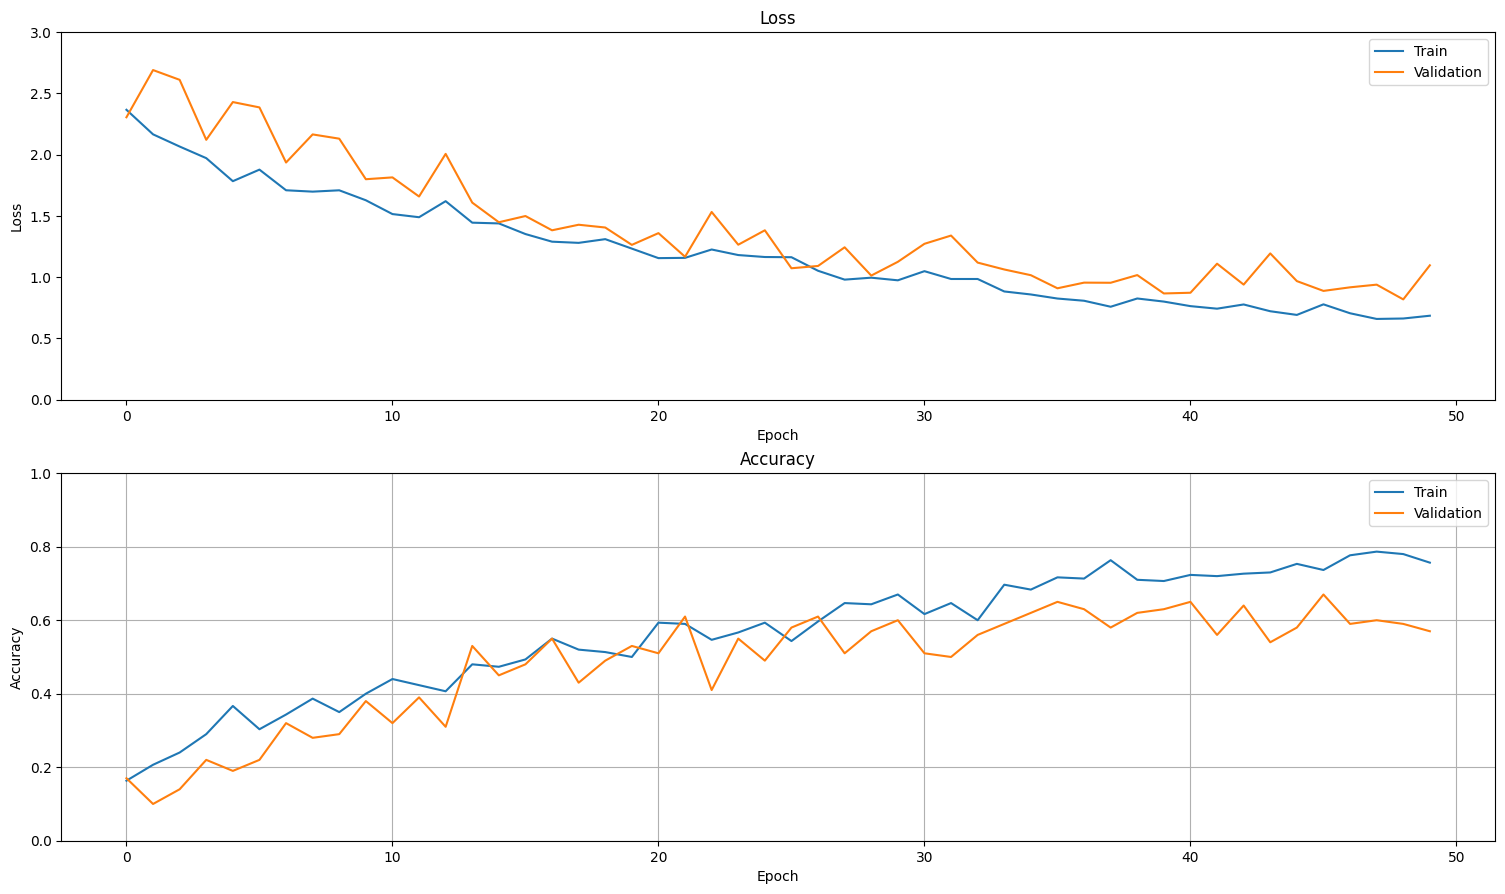

In [25]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)
  
  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.grid()
  plt.show()

plot_history(history)

## Evaluate the model

Use Keras `Model.evaluate` to get the loss and accuracy on the test dataset. 

Note: The example model in this tutorial uses a subset of the UCF101 dataset to keep training time reasonable. The accuracy and loss can be improved with further hyperparameter tuning or more training data. 

In [26]:
model.evaluate(test_ds, return_dict=True)

13/13 [==============================] - 10s 755ms/step - loss: 0.9549 - accuracy: 0.6300


{'loss': 0.9549070000648499, 'accuracy': 0.6299999952316284}

      7/Unknown 6s 850ms/step - accuracy: 0.6281 - loss: 0.9645

      8/Unknown 7s 831ms/step - accuracy: 0.6257 - loss: 0.9590

      9/Unknown 8s 833ms/step - accuracy: 0.6256 - loss: 0.9532

     10/Unknown 8s 819ms/step - accuracy: 0.6256 - loss: 0.9509

     11/Unknown 9s 830ms/step - accuracy: 0.6276 - loss: 0.9453

     12/Unknown 10s 823ms/step - accuracy: 0.6317 - loss: 0.9359

     13/Unknown 10s 781ms/step - accuracy: 0.6362 - loss: 0.9261

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 782ms/step - accuracy: 0.6400 - loss: 0.9176


2024-05-01 02:06:35.697737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:06:35.697779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


{'accuracy': 0.6899999976158142, 'loss': 0.8081037402153015}

To visualize model performance further, use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values. 

In [27]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [28]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [29]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

38/38 [==============================] - 31s 794ms/step


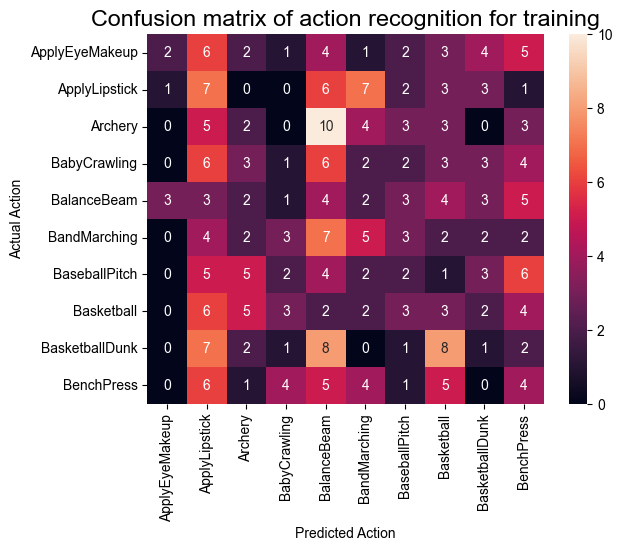

      7/Unknown 7s 738ms/step

      8/Unknown 8s 742ms/step

      9/Unknown 9s 752ms/step

     10/Unknown 10s 757ms/step

     11/Unknown 11s 779ms/step

     12/Unknown 11s 773ms/step

     13/Unknown 12s 771ms/step

     14/Unknown 13s 774ms/step

     15/Unknown 14s 787ms/step

     16/Unknown 15s 793ms/step

     17/Unknown 16s 796ms/step

     18/Unknown 16s 796ms/step

     19/Unknown 17s 792ms/step

     20/Unknown 18s 789ms/step

     21/Unknown 19s 788ms/step

     22/Unknown 19s 789ms/step

     23/Unknown 20s 787ms/step

     24/Unknown 21s 788ms/step

     25/Unknown 22s 796ms/step

     26/Unknown 23s 798ms/step

     27/Unknown 24s 801ms/step

     28/Unknown 24s 803ms/step

     29/Unknown 25s 802ms/step

     30/Unknown 26s 807ms/step

     31/Unknown 27s 808ms/step

     32/Unknown 28s 810ms/step

     33/Unknown 29s 813ms/step

     34/Unknown 30s 817ms/step

     35/Unknown 31s 817ms/step

     36/Unknown 32s 821ms/step

     37/Unknown 33s 825ms/step

     38/Unknown 35s 867ms/step

38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 867ms/step


2024-05-01 02:07:39.707651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


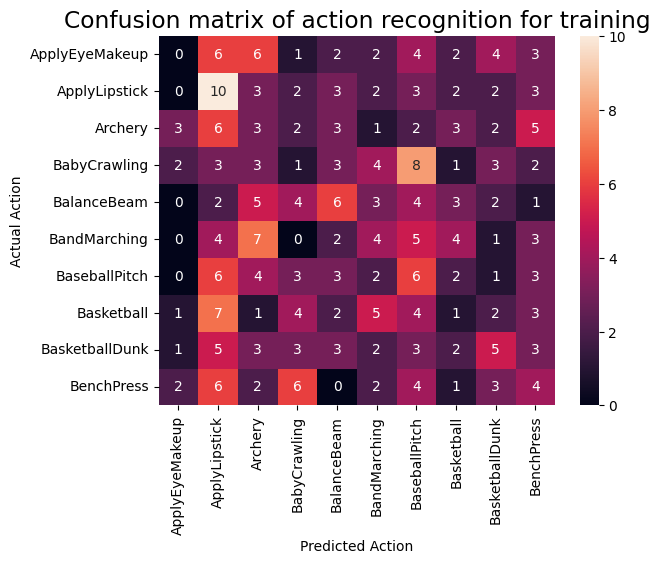

In [30]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

13/13 [==============================] - 10s 750ms/step


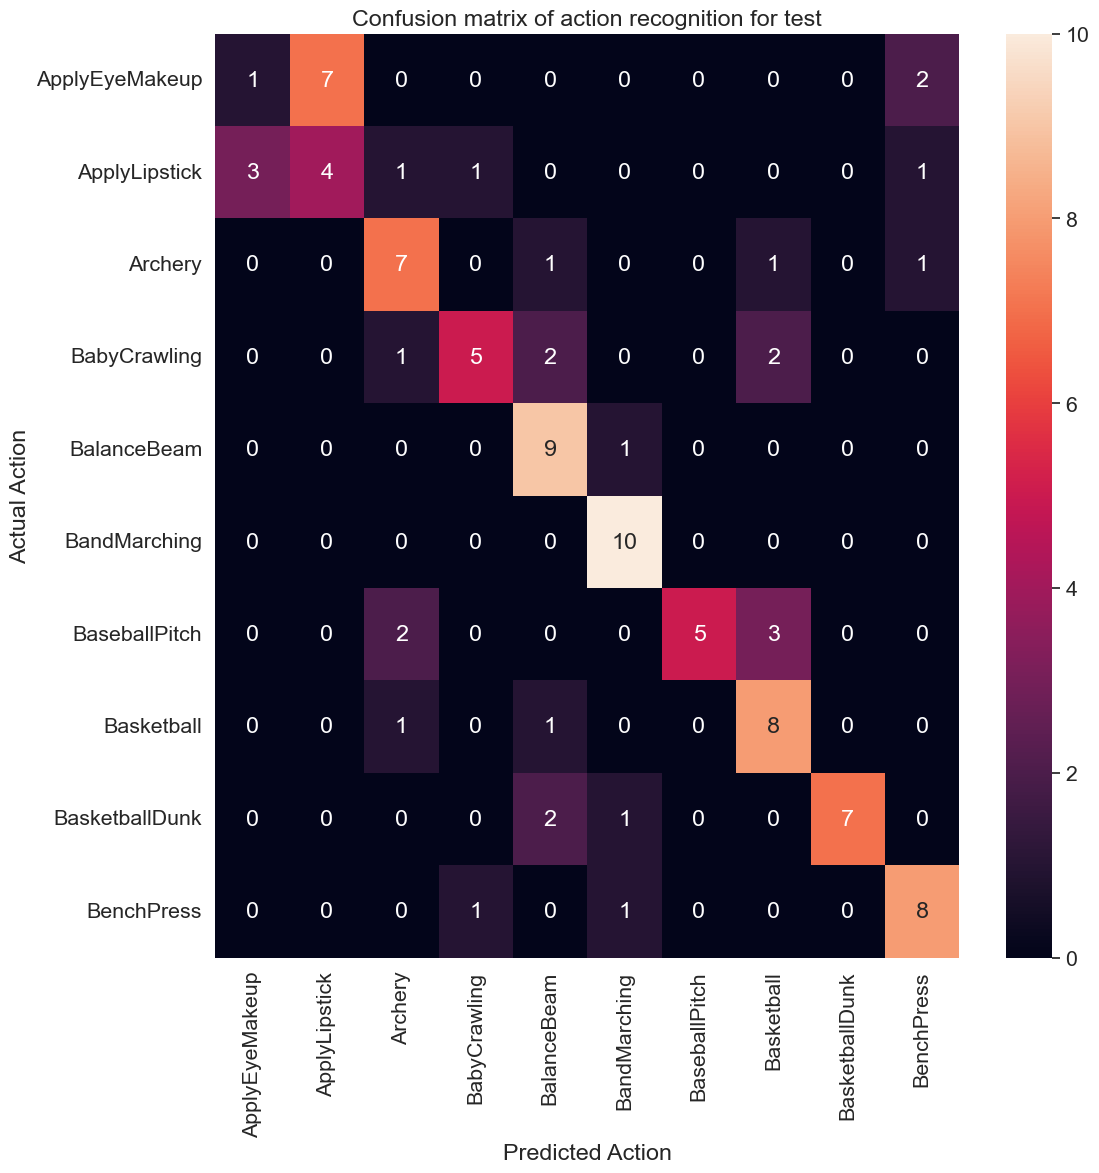

      7/Unknown 6s 866ms/step

      8/Unknown 7s 846ms/step

      9/Unknown 8s 853ms/step

     10/Unknown 9s 837ms/step

     11/Unknown 9s 843ms/step

     12/Unknown 10s 835ms/step

     13/Unknown 11s 796ms/step

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 797ms/step


/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-01 02:08:00.975486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


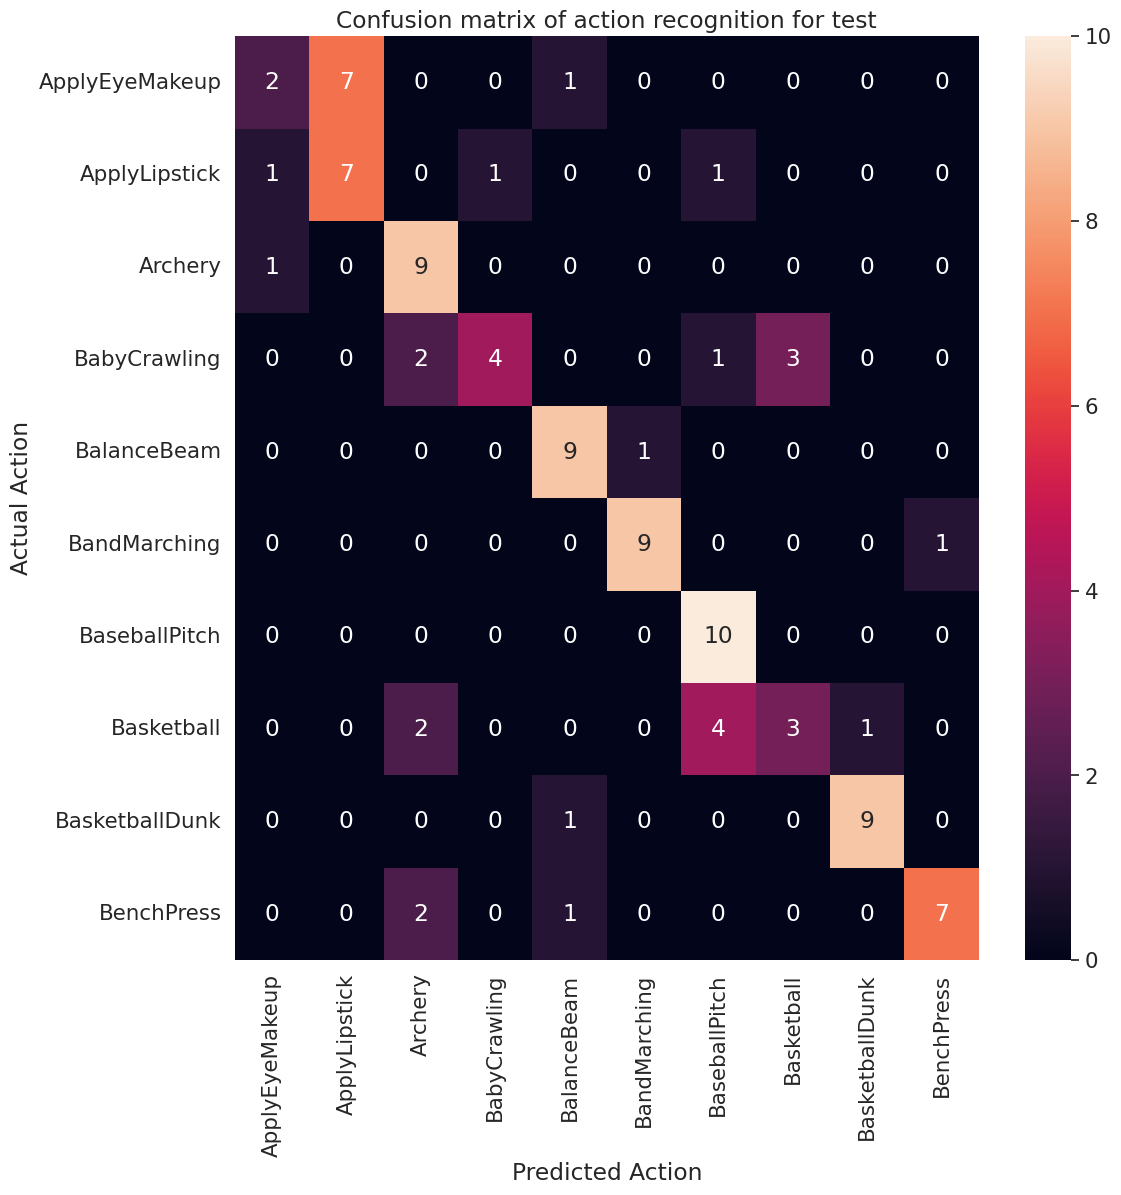

In [31]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

The precision and recall values for each class can also be calculated using a confusion matrix.

In [32]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [33]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [34]:
precision

{'ApplyEyeMakeup': 0.25,
 'ApplyLipstick': 0.36363636363636365,
 'Archery': 0.5833333333333334,
 'BabyCrawling': 0.7142857142857143,
 'BalanceBeam': 0.6,
 'BandMarching': 0.7692307692307693,
 'BaseballPitch': 1.0,
 'Basketball': 0.5714285714285714,
 'BasketballDunk': 1.0,
 'BenchPress': 0.6666666666666666}

In [35]:
recall

{'ApplyEyeMakeup': 0.1,
 'ApplyLipstick': 0.4,
 'Archery': 0.7,
 'BabyCrawling': 0.5,
 'BalanceBeam': 0.9,
 'BandMarching': 1.0,
 'BaseballPitch': 0.5,
 'Basketball': 0.8,
 'BasketballDunk': 0.7,
 'BenchPress': 0.8}

## Next steps

To learn more about working with video data in TensorFlow, check out the following tutorials:

* [Load video data](https://www.tensorflow.org/tutorials/load_data/video)
* [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet)
* [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet)